In [2]:
##Things to do - configure data augmentation and data preprocessing
# Need to count up each fracture type and balance accordingly.
import os
import glob
import pprint
import sys
#print(sys.path)
import shutil
import cv2
from PIL import Image
from PIL import PngImagePlugin
import json
import random
#import tensorflow as tf
import numpy as np
import torch
import math
import torch.nn.functional as F
from torchvision import transforms as T
#%pip install tensorflow
#from keras import layers
#from tensorflow import data as tf_data

from collections import Counter
import matplotlib.pyplot as pyplot
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/jpgzipped.zip
!unzip /content/drive/MyDrive/Faster_RCNN.zip

Streaming output truncated to the last 5000 lines.
  inflating: Faster_RCNN/train/4458_0369211753_01_WRI-L1_M014.xml  
  inflating: Faster_RCNN/train/4458_0369211789_01_WRI-L2_M014.jpg  
  inflating: Faster_RCNN/train/4458_0369211789_01_WRI-L2_M014.xml  
  inflating: Faster_RCNN/train/4459_0357088335_01_WRI-L2_F008.jpg  
  inflating: Faster_RCNN/train/4459_0357088335_01_WRI-L2_F008.xml  
  inflating: Faster_RCNN/train/4459_0357689606_02_WRI-L1_F008.jpg  
  inflating: Faster_RCNN/train/4459_0357689606_02_WRI-L1_F008.xml  
  inflating: Faster_RCNN/train/4459_0358983597_03_WRI-L1_F008.jpg  
  inflating: Faster_RCNN/train/4459_0358983597_03_WRI-L1_F008.xml  
  inflating: Faster_RCNN/train/4459_0358983642_03_WRI-L2_F008.jpg  
  inflating: Faster_RCNN/train/4459_0358983642_03_WRI-L2_F008.xml  
  inflating: Faster_RCNN/train/4460_0613088457_01_WRI-L2_M014.jpg  
  inflating: Faster_RCNN/train/4460_0613088457_01_WRI-L2_M014.xml  
  inflating: Faster_RCNN/train/4460_0613416392_02_WRI-L1_M014.jpg

In [ ]:
!unzip /content/drive/MyDrive/No_Fracture_pt1.zip -d /content/X-ray_Images/No\ Fracture
!unzip /content/drive/MyDrive/No_Fracture_pt2.zip -d /content/X-ray_Images/No\ Fracture
!unzip /content/drive/MyDrive/Fractured_pt1.zip -d /content/X-ray_Images/Fractured
!unzip /content/drive/MyDrive/Fractured_pt2.zip -d /content/X-ray_Images/Fractured

In [3]:
#@title spin
single_fractures = []
multi_fractures = []
unbroken = []
single_fracture_files = []
multi_fracture_files = []
single_fracture_ap = []
single_fracture_oblique = []
single_fracture_lat = []
single_fracture_left = []
single_fracture_right = []
multi_fracture_ap = []
multi_fracture_oblique = []
multi_fracture_lat = []
multi_fracture_left = []
multi_fracture_right = []
unbroken_ap = []
unbroken_oblique = []
unbroken_lat = []
unbroken_left = []
unbroken_right = []
path = '/Users/jenni/Desktop/Diss_Work/folder_structure/supervisely/wrist/ann'
for filename in glob.glob(os.path.join(path, '*.json')): #only process .JSON files in folder.
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        data=currentFile.read().replace('\n', '')
        keyword = json.loads(data)["tags"][0]
        tags = json.loads(data)["tags"]
        if type(keyword) is dict and keyword.get('name') == 'ao_classification':
            if ';' in keyword.get('value') :
                multi_fractures.append(keyword.get('value'))
                multi_fracture_files.append(filename)
                if 'side_right' in tags:
                    multi_fracture_right.append(filename)
                elif 'side_left' in tags:
                    multi_fracture_left.append(filename)
                else:
                    print(f"Side Label Missing {filename} has tag {tags}")
                if 'projection_ap' in tags:
                    multi_fracture_ap.append(filename)
                elif 'projection_lat' in tags:
                    multi_fracture_lat.append(filename)
                elif 'projection_oblique' in tags:
                    multi_fracture_oblique.append(filename)
                else:
                    print(f"Projection Label Missing {filename} has tag {tags}")
            else:
                single_fractures.append(keyword.get('value'))
                single_fracture_files.append(filename)
                if 'side_right' in tags:
                    single_fracture_right.append(filename)
                elif 'side_left' in tags:
                    single_fracture_left.append(filename)
                else:
                    print(f"Side Label Missing {filename} has tag {tags}")
                if 'projection_ap' in tags:
                    single_fracture_ap.append(filename)
                elif 'projection_lat' in tags:
                    single_fracture_lat.append(filename)
                elif 'projection_oblique' in tags:
                    single_fracture_oblique.append(filename)
                else:
                    print(f"Projection Label Missing {filename} has tag {tags}")
        else:
            unbroken.append(filename)
            if 'side_right' in tags:
                unbroken_right.append(filename)
            elif 'side_left' in tags:
                unbroken_left.append(filename)
            else:
                print(f"Side Label Missing {filename} has tag {tags}")
            if 'projection_ap' in tags:
                unbroken_ap.append(filename)
            elif 'projection_lat' in tags:
                unbroken_lat.append(filename)
            elif 'projection_oblique' in tags:
                unbroken_oblique.append(filename)
            else:
                print(f"Projection Label Missing {filename} has tag {tags}")
single_counter = Counter(single_fractures)
multi_counter = Counter(multi_fractures)
unbroken_counter = Counter(unbroken)

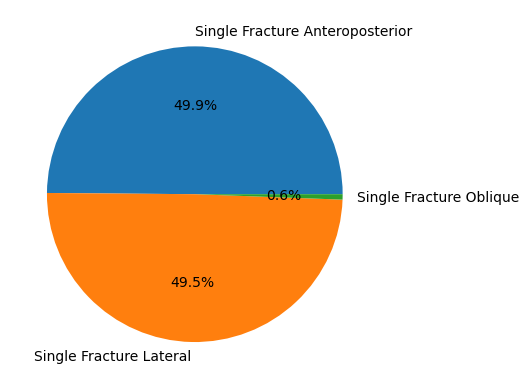

93


In [63]:
pyplot.pie([len(single_fracture_ap),len(single_fracture_lat),len(single_fracture_oblique)], labels = ['Single Fracture Anteroposterior', 'Single Fracture Lateral','Single Fracture Oblique'],autopct='%1.1f%%')
pyplot.show()
print(len(single_fracture_oblique) + len(unbroken_oblique)+len(multi_fracture_oblique))

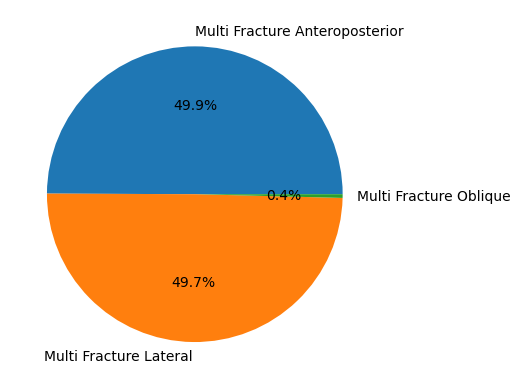

In [6]:
pyplot.pie([len(multi_fracture_ap),len(multi_fracture_lat),len(multi_fracture_oblique)], labels = ['Multi Fracture Anteroposterior', 'Multi Fracture Lateral','Multi Fracture Oblique'], autopct='%1.1f%%')
pyplot.show()

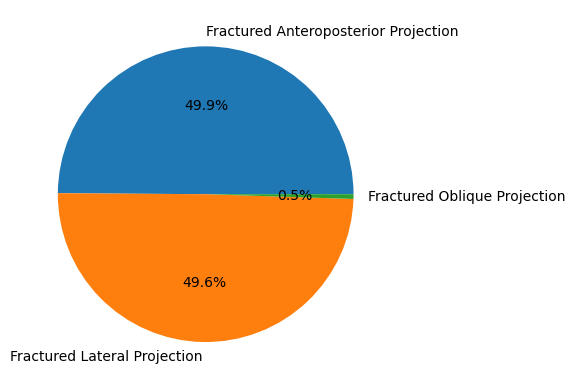

In [10]:
pyplot.pie([len(multi_fracture_ap)+ len(single_fracture_ap),len(multi_fracture_lat)+len(single_fracture_lat),len(multi_fracture_oblique)+len(single_fracture_oblique)], labels = ['Fractured Anteroposterior Projection', 'Fractured Lateral Projection','Fractured Oblique Projection'], autopct='%1.1f%%')
pyplot.show()

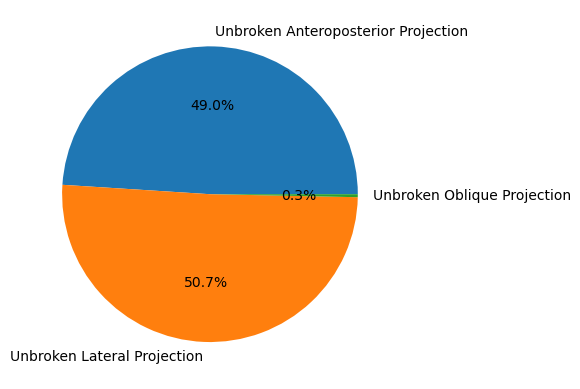

In [11]:
pyplot.pie([len(unbroken_ap),len(unbroken_lat),len(unbroken_oblique)], labels = ['Unbroken Anteroposterior Projection', 'Unbroken Lateral Projection','Unbroken Oblique Projection'], autopct="%1.1f%%")
pyplot.show()

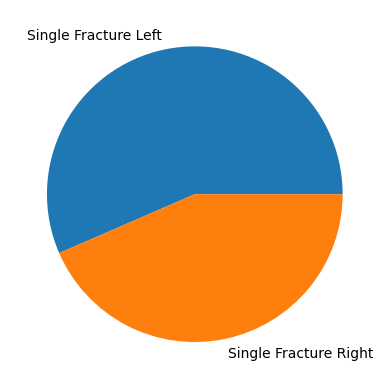

In [ ]:
pyplot.pie([len(single_fracture_left),len(single_fracture_right)], labels = ['Single Fracture Left', 'Single Fracture Right'])
pyplot.show()

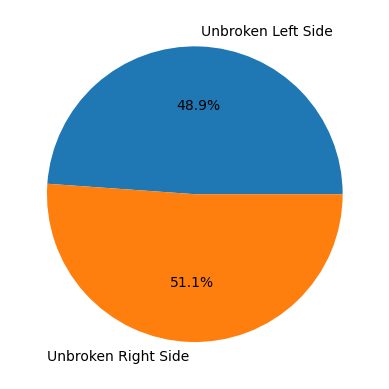

In [14]:
pyplot.pie([len(unbroken_left),len(unbroken_right)], labels = ['Unbroken Left Side', 'Unbroken Right Side'], autopct="%1.1f%%")
pyplot.show()

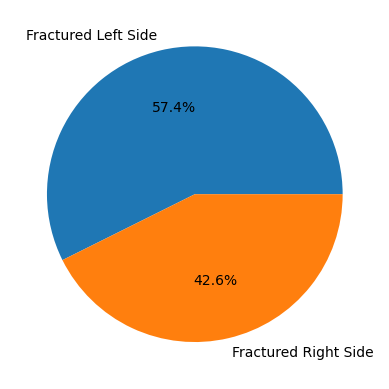

In [13]:
pyplot.pie([len(single_fracture_left)+len(multi_fracture_left),len(single_fracture_right)+len(multi_fracture_right)], labels = ['Fractured Left Side', 'Fractured Right Side'], autopct="%1.1f%%")
pyplot.show()

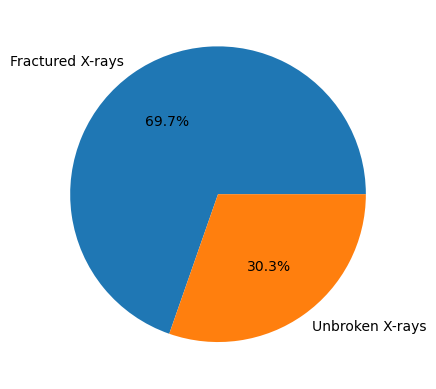

20327


In [51]:
#final_list = zip([float(v) for v in single_counter.values()],[single_counter])

#print(final_list[0])
#pyplot.pie(, labels=,
 #          autopct='%1.1f%%')
#pyplot.show()
pyplot.pie([len(single_fractures)+len(multi_fractures),len(unbroken_counter)], labels = ['Fractured X-rays', 'Unbroken X-rays'], autopct="%1.1f%%")
pyplot.show()
print(len(single_fractures)+len(multi_fractures)+len(unbroken_counter))

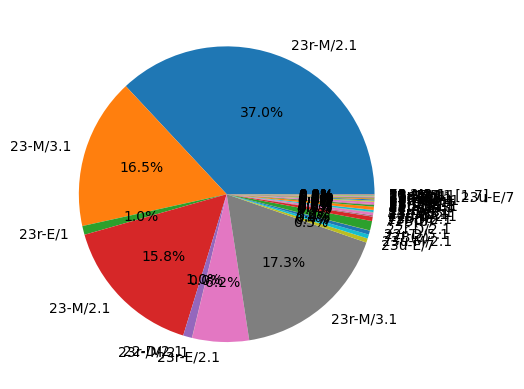

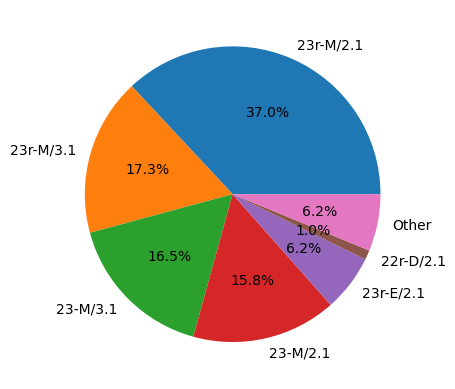

In [38]:
pyplot.pie([float(v) for v in single_counter.values()], labels=[k for k in single_counter],
           autopct="%1.1f%%")
pyplot.show()
import pandas as pd
df = pd.DataFrame(data = {"fracture_type":[k for k in single_counter], "count":[float(v) for v in single_counter.values()]}).sort_values('count', ascending = False)
#df_draw = df.copy()
df2 = df[:6].copy()

#others
new_row = pd.DataFrame(data = {
    'fracture_type' : ['Other'],
    'count' : [df['count'][6:].sum()]
})

#combining top 5 with others
df2 = pd.concat([df2, new_row])
pyplot.pie(df2["count"],labels=df2["fracture_type"], autopct="%1.1f%%")
pyplot.show()

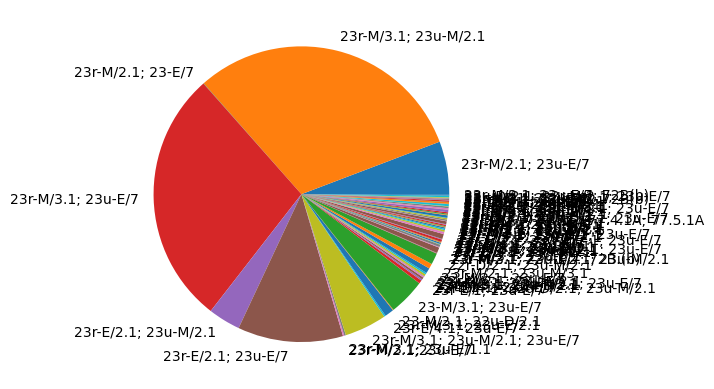

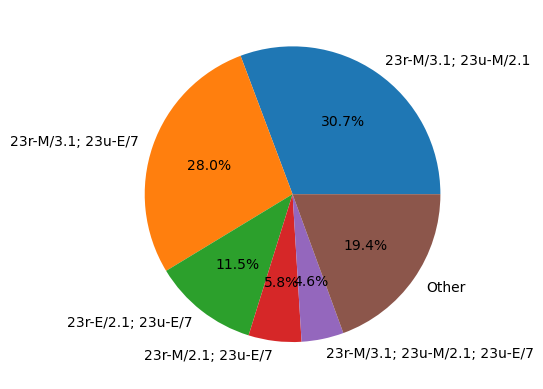

In [37]:
pyplot.pie([float(v) for v in multi_counter.values()], labels=[k for k in multi_counter],
           autopct=None)
pyplot.show()
df = pd.DataFrame(data = {"fracture_type":[k for k in multi_counter], "count":[float(v) for v in multi_counter.values()]}).sort_values('count', ascending = False)
#df_draw = df.copy()
df2 = df[:5].copy()

#others
new_row = pd.DataFrame(data = {
    'fracture_type' : ['Other'],
    'count' : [df['count'][5:].sum()]
})

#combining top 5 with others
df2 = pd.concat([df2, new_row])
pyplot.pie(df2["count"],labels=df2["fracture_type"], autopct="%1.1f%%")
pyplot.show()

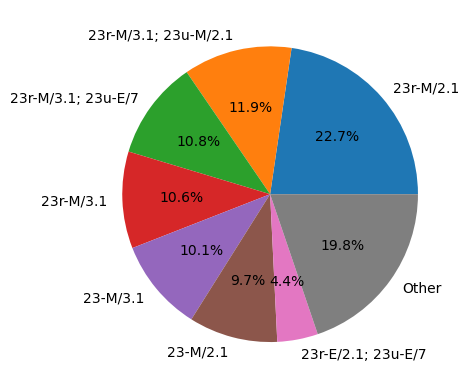

In [45]:
fracture_counter = single_counter + multi_counter
df = pd.DataFrame(data = {"fracture_type":[k for k in fracture_counter], "count":[float(v) for v in fracture_counter.values()]}).sort_values('count', ascending = False)
#df_draw = df.copy()
df2 = df[:7].copy()

#others
new_row = pd.DataFrame(data = {
    'fracture_type' : ['Other'],
    'count' : [df['count'][7:].sum()]
})

#combining top 5 with others
df2 = pd.concat([df2, new_row])
pyplot.pie(df2["count"],labels=df2["fracture_type"], autopct="%1.1f%%")
pyplot.show()

In [ ]:
#@title Alright, so we've figured out a few things:
# 23-M/3.1 - A distal radius fracture is 23, but instead of the A/B/C used for adults, pediatrics uses E, M, D
#(Epiphysis, metaphysis, and diaphyseal)
# The E/M/D is broken down into the type - E has 9 variants, M has 4, and D has 7
# The .1 or .2 is the severity of the break.
# Now, There's some discrepancies -
# Type 22 is a radius diaphyseal (in the middle), but still a radius break
# Type 72B(c) is a scaphoid simple fracture at the distal pole and subclass b is at the waist
# Type 77.2.1A (and other 77 variants) is damage to the metacarpals
# They're wrist x-rays, so it depends on how many examplesthere are
single_counter.most_common()
for (value, count) in single_counter.most_common():
    print(value,count)

In [ ]:
#@title I can trim off the severity marker (probably, i mean, it's good to have for archive but like. it's not going to help the model)
# Then i need to break off the multiple break ones i think....
# AGH some of them don't have the r/u marker on them. I'll have to take a look at them and see what no marker means.
# To do tomorrow - examine the ones without a marker and work with it. See how many can be combined and how many can be dumped.
# Make a note of which ones to be dumped and which ones to not - after combining, i would not be surprised if 22 and 77 were dumped
multi_counter.most_common()
for (value, count) in multi_counter.most_common():
    print(value,count)

 Okay, so for all the duplicates, they'll get added to the respective category (e.g. 23r-M/3.1; 23r-E/7 would get added to the
 23r-M/3 bucket and the 23r-E/7 bucket). After doing this, I can have a look and see if the radius/ulna split is necessary.
The basic buckets right now are:
- 23 break - broken down into E,D,M, then broken down by fracture type (1-9). Severity truncated
- 22 break - broken down into E/D/M, then by fracture type (1-9), severity truncated
- 77 break - broken down into finger (1 is thumb and go from there), then bone section (1,2,3), then fracture type. No severity
so 175 total buckets (20 for 23, 20 for 22, and 135 for hand)
But realistically all that matters is the split between breaks and no breaks.

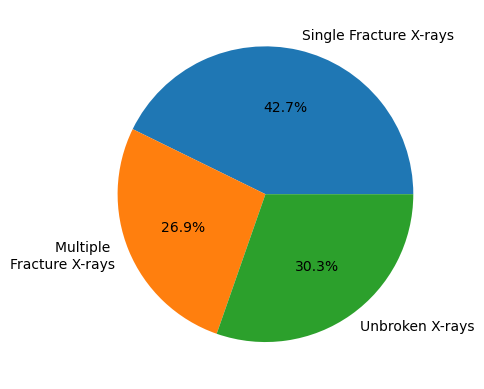

In [50]:
pyplot.pie([len(single_fractures),len(multi_fractures), len(unbroken)], labels = ['Single Fracture X-rays','Multiple \nFracture X-rays','Unbroken X-rays'], autopct='%1.1f%%')
pyplot.show()

28/01/2024 - So, first step of preprocessing is dividing the dataset into 3 groups - unbroken, single break, and multi-break.


In [ ]:
for value,count in single_counter.most_common():
    print(value,count)

23r-M/2.1 3211
23r-M/3.1 1499
23-M/3.1 1434
23-M/2.1 1375
23r-E/2.1 539
22r-D/2.1 90
23r-E/1 84
22-D/2.1 84
72B(b) 42
23u-E/7 40
23u-M/2.1 38
72B(c) 38
22-D/4.1 31
22u-D/2.1 25
23r-E/7 20
23r-E/3 18
22r-D/4.1 15
22-D/1.1 10
22r-D/1.1 10
23u-M/3.1 9
72B.(b) 8
23-E/2.1 8
23r-E/2.2 6
23u-E/4 5
23r-D/2.1 4
23r-M2.1 4
22u-D/1.1 4
77.1.1A 3
23r-E/2.1, 23u-E/7 3
23r-/M/2.1 2
22r-D/5.1 2
22-D/5.1 2
23r-D/3.1 2
23u-E/2.1 2
23-E/1 2
22r-M/2.1 2
23r-E/1  2
22r-D/1 2
77.5.1A 2
23r-M/2.1[1,7] 2
23r-E/3.1 2
23u-E/1 2
76.2.A 2
23-M2.1 2
23-M3.1 2


Looking at these, most of the ones with 2 files are user error (23-M3.1 for example, is missing its slash). For analysis, we'll group all 23 breaks, all 22 breaks, 77 breaks, and 72 breaks, just to see what the balance is like. If it seems to be becoming an issue down the line, we can adjust.

76.2.A


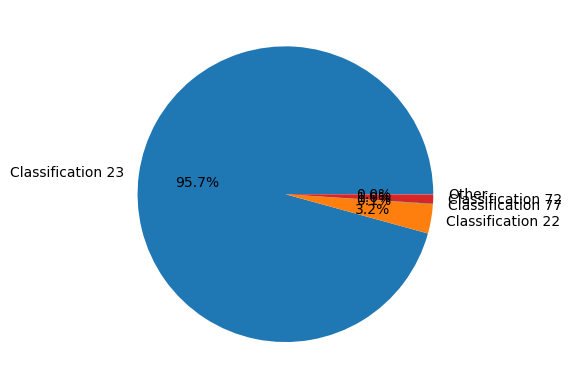

2
8317 277 5 88 2


In [54]:
#@title pie

list_23 = 0
list_22 = 0
list_77 = 0
list_72 = 0
other = 0
for key, value in single_counter.most_common():
    if '23'  in key:a
        list_23 += value
    elif '22'  in key:
        list_22 += value
    elif '77'  in key:
        list_77 += value
    elif '72'  in key:
        list_72 += value
    else:
        other += value
        print(key)
pyplot.pie([list_23,list_22,list_77,list_72, other], labels = ['Classification 23','Classification 22','Classification 77', 'Classification 72', 'Other'], autopct='%1.1f%%')
pyplot.show()
print(other)
print(list_23, list_22, list_77, list_72,other)

22r-D/2.1; 23u-M/2.1
22r-D/4.1; 23u-M/3.1
23r-M/3.1; 22u-D/4.1; 23u-E/7
22r-D/4.1; 23u-M/2.1
22r-D/4.1; 23u-E/7
22r-D/5.1; 23u-M/2.1
23r-M/3.1; 22u-D/1.1; 23u-E/7
22u-D/2.1; 23r-M/2.1; 23u-E/7
22r-D/4.1; 22u-D/2.1; 23u-M/2.1
23r-M/3.1; 22u-D/4.1
23r-M/3.1; 22u-D/2.1
22r-D/4.1; 23u-E/2.1
23-M/2.1; 22u-D/2.1
23r-E/2.1; 22u-D/1.1
23r-M/2.1; 22u-D/2.1
23r-M/2.1; 22u-D/1.1
22r-D/3.1; 23u-E/2.1
22r-D/1; 23u-M/3.1
23r-M/3.1; 22u-D/1.1
23r-M/2.1; 22r-D/2.1; 23u-M/2.1
23-M/3.1; 22r-D/4.1
22r-D/4.1; 22u-D/2.1
22-D/2.1; 23u-M/3.1
22r-D/2.1; 23u-M/3.1
22-D/2.1; 23u-E/7


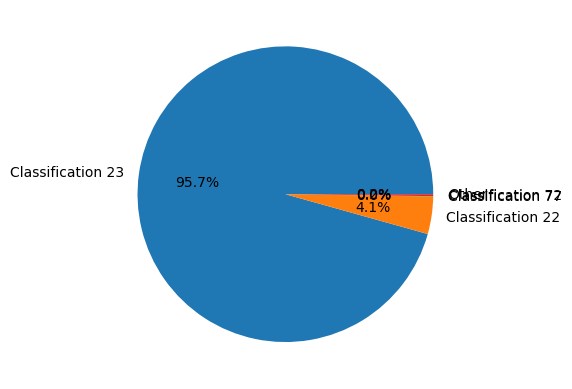

0
5465 234 2 12 0


In [62]:
list_23 = 0
list_22 = 0
list_77 = 0
list_72 = 0
other = 0
for key, value in multi_counter.most_common():
    if '23'  in key:
        list_23 += value
        #print(key)
    if '22'  in key:
        list_22 += value
        print(key)
    if '77'  in key:
        list_77 += value
    if '72'  in key:
        list_72 += value
    # else:
    #     other += value
    #     print(key)
pyplot.pie([list_23,list_22,list_77,list_72, other], labels = ['Classification 23','Classification 22','Classification 77', 'Classification 72', 'Other'], autopct='%1.1f%%')
pyplot.show()
print(other)
print(list_23, list_22, list_77, list_72,other)

So this shows it may have issues down the line identifying 22/77/72/76 breaks.


8689
6169


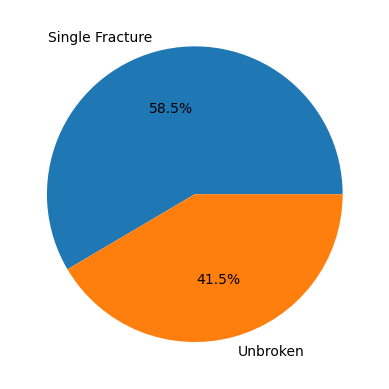

In [ ]:
print(len(single_fractures))
print(len(unbroken))
pyplot.pie([len(single_fractures),len(unbroken)], labels = ['Single Fracture', 'Unbroken'], autopct ='%1.1f%%')
pyplot.show()

# Augmentation to balance the dataset

So, we have 8689 single break images, and 6169 unbroken images. This means the unbroken images need to have 2520 augmented ones, before both categories are augmented for robustness. But first, we need to get the images into their respective folders.

In [ ]:
#@title Configure directories
directory1 = os.listdir("C:\\Users\\jenni\\Desktop\\Diss Work\\images_part1")
directory2 = os.listdir("C:\\Users\\jenni\\Desktop\\Diss Work\\images_part2")
directory3 = os.listdir("C:\\Users\\jenni\\Desktop\\Diss Work\\images_part3")
directory4 = os.listdir("C:\\Users\\jenni\\Desktop\\Diss Work\\images_part4")
single_break_dir = os.listdir("C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures")
multi_break_dir = os.listdir("C:\\Users\\jenni\\Desktop\\Diss Work\\Multi Fractures")
unbroken_dir = os.listdir("C:\\Users\\jenni\\Desktop\\Diss Work\\Unbroken")
fails = 0
success = 0
for fname in single_fracture_files:
    name_to_lookup = fname[fname.index('\\')+1:fname.index('.')]
    flag = False
    for filename_in_dir in directory1:
        path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part1\\' + str(filename_in_dir)
        if name_to_lookup in filename_in_dir:
            flag = True
            f = open(path,'r')
            if name_to_lookup not in single_break_dir:
                shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures")
                success+=1
            else:
                print("Already copied.")
            break
    if flag == False:
        for filename_in_dir in directory2:
            path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part2\\' + str(filename_in_dir)
            if name_to_lookup in filename_in_dir:
                flag = True
                f = open(path,'r')
                if name_to_lookup not in single_break_dir:
                    shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures")
                    success+=1
                else:
                    print("Already copied.")
                break
    if flag == False:
        for filename_in_dir in directory3:
            path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part3\\' + str(filename_in_dir)
            if name_to_lookup in filename_in_dir:
                flag = True
                f = open(path,'r')
                if name_to_lookup not in single_break_dir:
                    shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures")
                    success+=1
                else:
                    print("Already copied.")
                break
    if (flag == False):
        for filename_in_dir in directory4:
            path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part4\\' + str(filename_in_dir)
            if name_to_lookup in filename_in_dir:
                flag = True
                f = open(path,'r')
                if name_to_lookup not in single_break_dir:
                    shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures")
                    success+=1
                else:
                    print("Already copied.")
                break
    if flag == False:
        print(f"Image is missing for corresponding file:{name_to_lookup}")
        fails+=1
for fname in multi_fracture_files:
    name_to_lookup = fname[fname.index('\\')+1:fname.index('.')]
    flag = False
    for filename_in_dir in directory1:
        path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part1\\' + str(filename_in_dir)
        if name_to_lookup in filename_in_dir:
            flag = True
            f = open(path,'r')
            if name_to_lookup not in multi_fracture_files:
                shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Multi Fractures")
                success+=1
            else:
                print("Already copied.")
            break
    if flag == False:
        for filename_in_dir in directory2:
            path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part2\\' + str(filename_in_dir)
            if name_to_lookup in filename_in_dir:
                flag = True
                f = open(path,'r')
                if name_to_lookup not in multi_fracture_files:
                    shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Multi Fractures")
                    success+=1
                else:
                    print("Already copied.")
                break
    if flag == False:
        for filename_in_dir in directory3:
            path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part3\\' + str(filename_in_dir)
            if name_to_lookup in filename_in_dir:
                flag = True
                f = open(path,'r')
                if name_to_lookup not in multi_fracture_files:
                    shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Multi Fractures")
                    success+=1
                else:
                    print("Already copied.")
                break
    if (flag == False):
        for filename_in_dir in directory4:
            path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part4\\' + str(filename_in_dir)
            if name_to_lookup in filename_in_dir:
                flag = True
                f = open(path,'r')
                if name_to_lookup not in multi_fracture_files:
                    shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Multi Fractures")
                    success+=1
                else:
                    print("Already copied.")
                break
    if flag == False:
        print(f"Image is missing for corresponding file:{name_to_lookup}")
        fails+=1
for fname in unbroken:
    name_to_lookup = fname[fname.index('\\')+1:fname.index('.')]
    flag = False
    for filename_in_dir in directory1:
        path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part1\\' + str(filename_in_dir)
        if name_to_lookup in filename_in_dir:
            flag = True
            f = open(path,'r')
            if name_to_lookup not in unbroken:
                shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Unbroken")
                success+=1
            else:
                print("Already copied.")
            break
    if flag == False:
        for filename_in_dir in directory2:
            path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part2\\' + str(filename_in_dir)
            if name_to_lookup in filename_in_dir:
                flag = True
                f = open(path,'r')
                if name_to_lookup not in unbroken:
                    shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Unbroken")
                    success+=1
                else:
                    print("Already copied.")
                break
    if flag == False:
        for filename_in_dir in directory3:
            path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part3\\' + str(filename_in_dir)
            if name_to_lookup in filename_in_dir:
                flag = True
                f = open(path,'r')
                if name_to_lookup not in unbroken:
                    shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Unbroken")
                    success+=1
                else:
                    print("Already copied.")
                break
    if (flag == False):
        for filename_in_dir in directory4:
            path = 'C:\\Users\\jenni\\Desktop\\Diss Work\\images_part4\\' + str(filename_in_dir)
            if name_to_lookup in filename_in_dir:
                flag = True
                f = open(path,'r')
                if name_to_lookup not in unbroken:
                    shutil.copy(f.name, "C:\\Users\\jenni\\Desktop\\Diss Work\\Unbroken")
                    success+=1
                else:
                    print("Already copied.")
                break
    if flag == False:
        print(f"Image is missing for corresponding file:{name_to_lookup}")
        fails+=1

Okay, now everything is split out to the right folders (side note, clean this up later.) Next is the augmentation - for right now, ignore multifractures and augment the unbroken until the sizes are the same, then augment them both at the same rate. After that, preprocessing - the image needs to be straightened, and we're given the axis to adjust it on.
![image.png](attachment:d3b3182b-296b-482a-aa0b-ebd01f003d1a.png)

Let's write out these functions then. Each needs to apply the transform and create a new file with an appropriate appendage (eg cropping 5% would be _Crop5)
- flipping (done) https://stackoverflow.com/questions/51054427/flip-image-using-python
- rotating (done)
- cropping (done)https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
- saturation (done)
- hue(done)
- exposure (done)
Then, after that, i need the adjust axis function. which. hm.

In [ ]:
#@title augments
def flip_image_horizontal(filename, directory):
    img = cv2.imread(directory + filename)
    horizontal_img = cv2.flip(img, 0)
    final_path = directory + '\\Augmented\\' + filename[:filename.index('.')] + '_Horizontal_Flip.png'
    cv2.imwrite(final_path,horizontal_img)
def flip_image_vertical(filename, directory):
    img = cv2.imread(directory + filename)
    vertical_img = cv2.flip(img, 1)
    final_path = directory + '\\Augmented\\' + filename[:filename.index('.')] + '_Vertical_Flip.png'
    cv2.imwrite(final_path,vertical_img)
def rotate_image(filename,directory):
    img = Image.open(directory+filename)
    degrees = random.randrange(-9,9)
    if degrees == 0:
        degrees += random.randrange(1,9)
    rotated_img = img.rotate(degrees)
    final_path = directory + '\\Augmented\\' + filename[:filename.index('.')] + '_Rotated_' + str(degrees) +'.png'
    rotated_img.save(final_path)
def zoom_image(filename,directory):
    img = cv2.imread(directory + filename).copy()
    zoom_per = random.randrange(1,10)
    zoom_per = (zoom_per/100)+1
    height, width = img.shape[:2]
    new_height, new_width = int(height * zoom_per), int(width * zoom_per)
    y1, x1 = max(0, new_height-height) //2, max(0, new_width-width) //2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    bbox = (bbox/zoom_per).astype(int)
    y1,x1,y2,x2 = bbox
    zoomed_img = img[y1:y2,x1:x2]
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    result_img = cv2.resize(zoomed_img, (resize_width, resize_height))
    result_img = np.pad(result_img, pad_spec, mode='constant')
    final_path = directory + '\\Augmented\\' + filename[:filename.index('.')] + '_Zoomed_' + str(int((zoom_per-1)*100)) +'.png'
    cv2.imwrite(final_path,result_img)
def adjust_img_saturation(filename, directory):
    img = cv2.imread(directory + filename)
    saturation_per = random.randrange(-42,43)
    if saturation_per == 0:
        saturation_per += random.randrange(1,43)
    saturated_img = tf.image.adjust_saturation(img, saturation_per/10.0)
    final_path = directory + '\\Augmented\\' + filename[:filename.index('.')] + '_Saturated_' + str(saturation_per) +'.png'
    tf.keras.utils.save_img(final_path, saturated_img)
def adjust_img_hue(filename, directory):
    img = cv2.imread(directory + filename)
    hue_per = random.randrange(-44,45)
    if hue_per == 0:
        hue_per += random.randrange(1,45)
    hue_img = tf.image.adjust_hue(img, (hue_per/100))
    final_path = directory + '\\Augmented\\' + filename[:filename.index('.')] + '_Hue_' + str(hue_per) +'.png'
    tf.keras.utils.save_img(final_path, hue_img)
def adjust_img_contrast(filename,directory):
    img = cv2.imread(directory + filename)
    contrast_per = random.randrange(-11,12)
    if contrast_per ==  0:
        contrast_per += random.randrange(1,12)
    contrast_img = tf.image.adjust_contrast(img, (contrast_per/100.0 + 1))
    final_path = directory + '\\Augmented\\' + filename[:filename.index('.')] + '_Contrast_' + str(contrast_per) +'.png'
    tf.keras.utils.save_img(final_path, contrast_img)
#flip_image_horizontal("0001_1297860395_01_WRI-L1_M014.png","C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures\\")
#flip_image_vertical("0001_1297860395_01_WRI-L1_M014.png","C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures\\")
#rotate_image("0001_1297860395_01_WRI-L1_M014.png","C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures\\")
#zoom_image("0001_1297860395_01_WRI-L1_M014.png","C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures\\")
#adjust_img_saturation("0001_1297860395_01_WRI-L1_M014.png","C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures\\")
#adjust_img_hue("0001_1297860395_01_WRI-L1_M014.png","C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures\\")
#adjust_img_contrast("0001_1297860395_01_WRI-L1_M014.png","C:\\Users\\jenni\\Desktop\\Diss Work\\Single Fractures\\")

### Whoops, i forgot abt posterior/anterior framing. Should also balance that.
update 01/02/24 - it's basically balanced already!!

Great, the functions for preprocessing are done - to do tomorrow is augmenting the data. Then we can actually construct the model!

https://stackoverflow.com/questions/32435488/align-x-ray-images-find-rotation-rotate-and-crop
This is good for the rotation steps

In [ ]:
#@title augment
def augment_data(directory, count_to_match):
    starting_val = len(os.listdir(directory))-1
    #Subtract one to account for the Augmented Folder
    for file in os.listdir(directory):
        aug_method = random.randrange(0,7)
        if aug_method == 0:
            flip_image_horizontal(file, directory)
        elif aug_method == 1:
            flip_image_vertical(file,directory)
        elif aug_method == 2:
            rotate_image(file, directory)
        elif aug_method == 3:
            zoom_image(file, directory)
        elif aug_method == 4:
            adjust_img_saturation(file, directory)
        elif aug_method == 5:
            adjust_img_hue(file,directory)
        elif aug_method == 6:
            adjust_img_contrast(file, directory)
        starting_val += 1
        if starting_val >= count_to_match:
            break
    #verify counts
    subfolder = directory + "\\Augmented\\"
    if (len(os.listdir(directory))-1) + len(os.listdir(directory + "\\Augmented\\")) == count_to_match:
        print(f"Count verified, total of {count_to_match} images with {len(os.listdir(directory))-1} original and {len(os.listdir(subfolder))} augmented.")
    else:
        print(f"Incorrect amount. Meant to have {count_to_match}, found {(len(os.listdir(directory))-1) + len(os.listdir(subfolder))} .")

augment_data("C:\\Users\\jenni\\Desktop\\Diss Work\\Unbroken\\", 8689)

Count verified, total of 8689 images with 6170 original and 2520 augmented.


Time to construct the model now - preprocessing-resnext

In [ ]:
!dir X-Ray_Images

 Volume in drive C is OS
 Volume Serial Number is 941D-05AD

 Directory of C:\Users\jenni\Desktop\Diss Work\X-Ray_Images

04/02/2024  05:04 PM    <DIR>          .
04/02/2024  05:24 PM    <DIR>          ..
04/02/2024  05:07 PM    <DIR>          Fractured
04/02/2024  05:07 PM    <DIR>          No Fracture
               0 File(s)              0 bytes
               4 Dir(s)  109,555,712,000 bytes free


In [ ]:
image_size = (256,256) #this will prob need to change - x-rays are bigger and fractures are tiny
batch_size = 128
train_ds, test_ds = keras.utils.image_dataset_from_directory(
    "X-Ray_Images",
    validation_split = 0.2,
    subset = "both",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size
)


Found 17378 files belonging to 2 classes.
Using 13903 files for training.
Using 3475 files for validation.


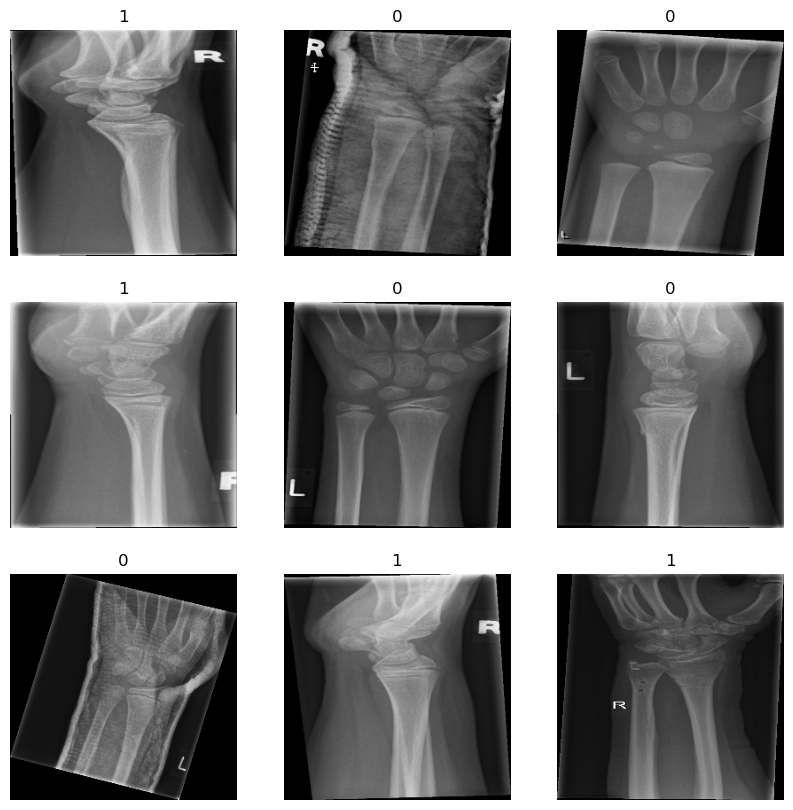

In [ ]:
pyplot.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = pyplot.subplot(3, 3, i + 1)
        pyplot.imshow(np.array(images[i]).astype("uint8"))
        pyplot.title(int(labels[i]))
        pyplot.axis("off")


In [ ]:
#This is where the augmentation would go if needed, but the dataset is already comically large
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

###

In [ ]:
class AdjustImage(object):
    THRESHOLD = 240
    def subimage(self, image, center, theta, width, height):
        if 45 < theta <= 90:
            theta = theta - 90
            width, height = height, width

        theta *= math.pi / 180 # convert to rad
        v_x = (math.cos(theta), math.sin(theta))
        v_y = (-math.sin(theta), math.cos(theta))
        s_x = center[0] - v_x[0] * (width / 2) - v_y[0] * (height / 2)
        s_y = center[1] - v_x[1] * (width / 2) - v_y[1] * (height / 2)
        mapping = np.array([[v_x[0],v_y[0], s_x], [v_x[1],v_y[1], s_y]])
        return cv2.warpAffine(image, mapping, (width, height), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_REPLICATE)
    def __call__(self, image_source):
         # First slightly crop edge - some images had a rogue 2 pixel black edge on one side
        #https://github.com/python-pillow/Pillow/issues/6765 - pil issue with pngs
        #type_var = image_source.format
        #image_source.show()

        #image_source.save("/content/Images/source0.bmp")
        image_source_original = image_source
        image_source = np.asarray(image_source)
        #na = (np.array(image_source)>>8).astype(np.uint8)
        #na = Image.fromarray(na)
        #na.show()
        """if isinstance(image_source, np.ndarray):
            print("working")
        elif image_source.format == 'JPEG':
            image_source = np.array(image_source)
            image_source = image_source[:,:,::-1].copy()
        else:
            image_source = np.asarray(image_source).astype(float)/256.0"""
            #image_source = image_source.convert('RGB')
            #image_source.show(title="After Conversion")
            #image_source = np.array(image_source)
            #image_source = image_source[:,:,::-1].copy()

            #This method was designed and tested on using cv2.imread - these steps change a PIL PNG read into that.
            #Otherwise, it will destroy the image
        #cv2.imwrite("/content/Images/source1.jpg", image_source)
        init_crop = 5
        dimensions = image_source.ndim
        h, w = image_source.shape[:2]
        image_source = image_source[init_crop:init_crop+(h-init_crop*2), init_crop:init_crop+(w-init_crop*2)]
        #cv2.imwrite("/content/Images/source2.jpg", image_source)
        # Add back a white border
        image_source = cv2.copyMakeBorder(image_source, 5,5,5,5, cv2.BORDER_CONSTANT, value=(255,255,255))
        #cv2.imwrite("/content/Images/source3.jpg", image_source)
        if dimensions == 2:
            image_gray = image_source.copy()
        else:
            image_gray = cv2.cvtColor(image_source, cv2.COLOR_BGR2GRAY)
        _, image_thresh = cv2.threshold(image_gray, self.THRESHOLD, 255, cv2.THRESH_TOZERO_INV)
        #cv2.imwrite("/content/Images/thresh.jpg", image_thresh)
        #cv2.imwrite("/content/Images/gray.jpg", image_gray)
        image_thresh2 = image_thresh.copy()
        image_thresh2 = cv2.Canny(image_thresh2, 100, 100, apertureSize=3)

        points = cv2.findNonZero(image_thresh2)

        centre, dimensions, theta = cv2.minAreaRect(points)
        rect = cv2.minAreaRect(points)

        width = int(dimensions[0])
        height = int(dimensions[1])

        box = cv2.boxPoints(rect)
        box = np.int0(box)

        temp = image_source.copy()
        cv2.drawContours(temp, [box], 0, (255,0,0), 2)

        M = cv2.moments(box)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])

        image_patch = self.subimage(image_source, (cx, cy), (theta+90), height, width)

        # add back a small border
        image_patch = cv2.copyMakeBorder(image_patch, 1,1,1,1, cv2.BORDER_CONSTANT, value=(255,255,255))

        # Convert image to binary, edge is black. Do edge detection and convert edges to a list of points.
        # Then calculate a minimum set of points that can enclose the points.
        _, image_thresh = cv2.threshold(image_patch, self.THRESHOLD, 255, 1)
        image_thresh = cv2.Canny(image_thresh, 100, 100, 3)
        points = cv2.findNonZero(image_thresh)
        hull = cv2.convexHull(points)

        # Find min epsilon resulting in exactly 4 points, typically between 7 and 21
        # This is the smallest set of 4 points to enclose the image.
        for epsilon in range(3, 50):
            hull_simple = cv2.approxPolyDP(hull, epsilon, 1)

            if len(hull_simple) == 4:
                break

        hull = hull_simple

        # Find closest fitting image size and warp/crop to fit
        # (ie reduce scaling to a minimum)

        x,y,w,h = cv2.boundingRect(hull)
        target_corners = np.array([[0,0],[w,0],[w,h],[0,h]], np.float32)

        # Sort hull into tl,tr,br,bl order.
        # n.b. hull is already sorted in clockwise order, we just need to know where top left is.

        source_corners = hull.reshape(-1,2).astype('float32')
        #if len(source_corners) != 4:
        #    cv2.imwrite("C:\\Users\\jenni\\Desktop\\Diss_Work\\Testing\\hull.jpg", image_source)
        min_dist = 100000
        index = 0

        for n in range(len(source_corners)):
            x,y = source_corners[n]
            dist = math.hypot(x,y)

            if dist < min_dist:
                index = n
                min_dist = dist

        # Rotate the array so tl is first
        source_corners = np.roll(source_corners , -(2*index))

        try:

            transform = cv2.getPerspectiveTransform(np.float32(source_corners), np.float32(target_corners))
            var = Image.fromarray(cv2.warpPerspective(image_patch, transform, (w,h))).convert('RGB')
            return var
             #Image.fromarray(cv2.warpPerspective(image_patch, transform, (w,h))).convert('RGB')

        except Exception as inst:
            # print(type(inst))    # the exception type

            # print(inst.args)     # arguments stored in .args

            # print(inst)          # __str__ allows args to be printed directly,
            # print(source_corners)
            # print(target_corners)
            # print(x,y,w,h)
            #print ("Warp failure")
            return image_source_original

    def __repr__(self):
        return self.__class__.__name__+'()'


In [ ]:
!rm -rf /content/X-ray_Images


In [ ]:
#@title from google.colab.patches import cv2_imshow
img = cv2.imread("/content/X-ray_Images/No Fracture/0004_0542630449_01_WRI-L1_M003_Saturated_-30.png")
cv2_imshow(img)
cv2.imwrite('/content/X-ray_Images/image_test.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
filename = "0004_0542630449_01_WRI-L1_M003.png"
if filename[30] == '_':
  print("Augmented")
elif filename[30] == ".":
  print("normal")

In [ ]:
from google.colab.patches import cv2_imshow
#img = cv2.imread("/content/X-ray_Images/0809_0408005841_02_WRI-L2_F007.png")
#cv2_imshow(img)

#png_file_paths = glob.glob("/content/X-ray_Images/Fractured")
for filename in os.listdir("/content/X-ray_Images/No Fracture"):
    if filename[30] == '_':
      img = cv2.imread("/content/X-ray_Images/No Fracture/" + filename)
      print(filename)
      savestring = "/content/X-ray_Images/JPG/No Fracture/" + filename[:-3] + "jpg"
      cv2.imwrite(savestring, img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    elif filename[30] == '.':
      jpg_file_path ="/content/X-ray_Images/JPG/No Fracture/";
      print(filename)
      # Load .png image
      #image = cv2.imread("/content/X-ray_Images/Fractured_1/" + filename,cv2.IMREAD_UNCHANGED)
      image = Image.fromarray((np.array(Image.open("/content/X-ray_Images/No Fracture/" + filename))>>8).astype(np.uint8)).convert('RGB')
      # Save .jpg image
      #cv2.imwrite(jpg_file_path, image)
      image.save(jpg_file_path + filename[:-3] + "jpg")
    else:
      print("error" + filename)

    pass

In [ ]:
from google.colab.patches import cv2_imshow
#img = cv2.imread("/content/X-ray_Images/0809_0408005841_02_WRI-L2_F007.png")
#cv2_imshow(img)

#png_file_paths = glob.glob("/content/X-ray_Images/Fractured")
for filename in os.listdir("/content/X-ray_Images/Fractured"):
    print(filename)
    if filename[30] == '_':
      img = cv2.imread("/content/X-ray_Images/Fractured/" + filename)
      print(filename)
      savestring = "/content/X-ray_Images/JPG/Fractured/" + filename[:-3] + "jpg"
      cv2.imwrite(savestring, img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    elif filename[30] == '.':
      jpg_file_path ="/content/X-ray_Images/JPG/Fractured/";
      print(filename)
      # Load .png image
      #image = cv2.imread("/content/X-ray_Images/Fractured_1/" + filename,cv2.IMREAD_UNCHANGED)
      image = Image.fromarray((np.array(Image.open("/content/X-ray_Images/Fractured/" + filename))>>8).astype(np.uint8)).convert('RGB')
      # Save .jpg image
      #cv2.imwrite(jpg_file_path, image)
      image.save(jpg_file_path + filename[:-3] + "jpg")
    else:
      print("error" + filename)

    pass

In [ ]:
for filename in os.listdir("/content/X-ray_Images/JPG/No Fracture"):
  img = Image.open("/content/X-ray_Images/JPG/No Fracture/"+ filename)
  if not img.getbbox():
    img.show()
    print(filename)



In [ ]:
for filename in os.listdir("/content/X-ray_Images/JPG/Fractured"):
  img = Image.open("/content/X-ray_Images/JPG/Fractured/"+ filename)
  if not img.getbbox():
    img.show()
    print(filename)


3205_1060479857_01_WRI-L2_F006

4326_1095780083_01_WRI-L2_F008.jpg

3205_1060479807_01_WRI-L1_F006.jpg

2372_0273133564_01_WRI-R2_M004.png

1296_0590400053_01_WRI-L1_F005.jpg

1122_0300776689_01_WRI-L1_M014_Rotated_-8

0207_0930178796_01_WRI-L2_F016

1922_0873256740_01_WRI-R1_F015

EVERY AUGMENTED IMAGE IS INCORRECTLY COVERTED TO JPG, MAKING IT A BLACK SQUaRE. FOR TOmORROW, FIGURE OUT THE CONVERTION ^all those are dodgy alraedy


In [ ]:
#@title for filename in os.listdir("/content/X-ray_Images/JPG/No_Fracture"):
try:
  img = Image.open("/content/X-ray_Images/JPG/No_Fracture/1296_0590400053_01_WRI-L1_F005_Saturated_1.jpg")
  #print(filename)
  result = AdjustImage()
  img = result(img)
  img.save("/content/X-ray_Images/JPG/Adjusted/1296_0590400053_01_WRI-L1_F005_Saturated_1.jpg")
except Exception as e:
  print(e)
  print(filename)
  print(img)
  img.show()
  #pyplot.imshow(img)
  #pyplot.show()


In [ ]:
#@title test
adj_img = AdjustImage()
cv2_img = cv2.imread("C:\\Users\\jenni\\Desktop\\Diss_Work\\Testing\\0020_0163123912_01_WRI-L1_M015.png")
print(type(cv2_img))
img = Image.open("C:\\Users\\jenni\\Desktop\\Diss_Work\\Testing\\0020_0163123912_01_WRI-L1_M015.png")
img2 = img.copy()
"""print(type(img))
print(type(img))
#img.convert('BGR').save("C:\\Users\\jenni\\Desktop\\Diss Work\\X-Ray_Images\\cropped xray10.png","JPEG")
print(type(img))
#cv2.imwrite("C:\\Users\\jenni\\Desktop\\Diss Work\\X-Ray_Images\\cropped xray6.png", img)
print(type(img2))"""
img = img.point(lambda x: x / 256)
img = img.convert('RGB')
"""img.save("C:\\Users\\jenni\\Desktop\\Diss Work\\X-Ray_Images\\cropped xray11.png")

print(type(img))
img = np.asarray(img)
img = img[:, :, ::-1]
print(type(img))"""
#img.show()
img2 = adj_img(img2)
#img2.show()
cv2.imwrite("C:\\Users\\jenni\\Desktop\\Diss Work\\X-Ray_Images\\cropped xray12.jpg", img2)

In [ ]:
#@title test
#Custom Transform to straighten up the x-ray https://stackoverflow.com/questions/32435488/align-x-ray-images-find-rotation-rotate-and-crop

import math
class AdjustRotation(object):
    THRESHOLD = 240

    def subimage(image, center, theta, width, height):
        if 45 < theta <= 90:
            theta = theta - 90
            width, height = height, width

        theta *= math.pi / 180 # convert to rad
        v_x = (math.cos(theta), math.sin(theta))
        v_y = (-math.sin(theta), math.cos(theta))
        s_x = center[0] - v_x[0] * (width / 2) - v_y[0] * (height / 2)
        s_y = center[1] - v_x[1] * (width / 2) - v_y[1] * (height / 2)
        mapping = np.array([[v_x[0],v_y[0], s_x], [v_x[1],v_y[1], s_y]])
        return cv2.warpAffine(image, mapping, (width, height), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_REPLICATE)
    def __init__(self):
        print("Working?")
    def __call__(self, image_source):
        # First slightly crop edge - some images had a rogue 2 pixel black edge on one side
        init_crop = 5
        h, w = image_source.shape[:2]
        image_source = image_source[init_crop:init_crop+(h-init_crop*2), init_crop:init_crop+(w-init_crop*2)]

        # Add back a white border
        image_source = cv2.copyMakeBorder(image_source, 5,5,5,5, cv2.BORDER_CONSTANT, value=(255,255,255))

        image_gray = cv2.cvtColor(image_source, cv2.COLOR_BGR2GRAY)
        _, image_thresh = cv2.threshold(image_gray, THRESHOLD, 255, cv2.THRESH_TOZERO_INV)
        image_thresh2 = image_thresh.copy()
        image_thresh2 = cv2.Canny(image_thresh2, 100, 100, apertureSize=3)
        points = cv2.findNonZero(image_thresh2)

        centre, dimensions, theta = cv2.minAreaRect(points)
        rect = cv2.minAreaRect(points)

        width = int(dimensions[0])
        height = int(dimensions[1])

        box = cv2.boxPoints(rect)
        box = np.int0(box)

        temp = image_source.copy()
        cv2.drawContours(temp, [box], 0, (255,0,0), 2)

        M = cv2.moments(box)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])

        image_patch = subimage(image_source, (cx, cy), theta+90, height, width)

        # add back a small border
        image_patch = cv2.copyMakeBorder(image_patch, 1,1,1,1, cv2.BORDER_CONSTANT, value=(255,255,255))

        # Convert image to binary, edge is black. Do edge detection and convert edges to a list of points.
        # Then calculate a minimum set of points that can enclose the points.
        _, image_thresh = cv2.threshold(image_patch, THRESHOLD, 255, 1)
        image_thresh = cv2.Canny(image_thresh, 100, 100, 3)
        points = cv2.findNonZero(image_thresh)
        hull = cv2.convexHull(points)

        # Find min epsilon resulting in exactly 4 points, typically between 7 and 21
        # This is the smallest set of 4 points to enclose the image.
        for epsilon in range(3, 50):
            hull_simple = cv2.approxPolyDP(hull, epsilon, 1)

            if len(hull_simple) == 4:
                break

        hull = hull_simple

        # Find closest fitting image size and warp/crop to fit
        # (ie reduce scaling to a minimum)

        x,y,w,h = cv2.boundingRect(hull)
        target_corners = np.array([[0,0],[w,0],[w,h],[0,h]], np.float32)

        # Sort hull into tl,tr,br,bl order.
        # n.b. hull is already sorted in clockwise order, we just need to know where top left is.

        source_corners = hull.reshape(-1,2).astype('float32')
        min_dist = 100000
        index = 0

        for n in range(len(source_corners)):
            x,y = source_corners[n]
            dist = math.hypot(x,y)

            if dist < min_dist:
                index = n
                min_dist = dist

        # Rotate the array so tl is first
        source_corners = np.roll(source_corners , -(2*index))

        try:
            transform = cv2.getPerspectiveTransform(source_corners, target_corners)
            return cv2.warpPerspective(image_patch, transform, (w,h))

        except:
            print ("Warp failure")
            return image_patch





#image_src = cv2.imread("C:\\Users\\jenni\\Desktop\\Diss Work\\X-Ray_Images\\0020_0163123912_01_WRI-L1_M015.png")
#image_cropped = auto_crop(image_src)
#cv2.imwrite("C:\\Users\\jenni\\Desktop\\Diss Work\\X-Ray_Images\\cropped xray2.png", image_cropped)


In [ ]:
transforms = v2.Compose([AdjustImage(), v2.Resize([256,256]), v2.PILToTensor()])

In [ ]:
#Constructing the ResNeXt model:
#Okay, we've swapped to Pytorch instead of Tensorflow, since tensorflow seems intent on giving me a headache
xray_dataset = datasets.ImageFolder("/content/X-ray_Images/JPG", transform=transforms)
train_ds, test_ds, val_ds = torch.utils.data.random_split(xray_dataset, [0.8,0.1,0.1],generator=torch.Generator().manual_seed(42))
#train_ds = datasets.ImageFolder("C:\\Users\\jenni\\Desktop\\Diss_Work\\X-ray_Images\\train", transform = transforms, loader=lambda path: Image.fromarray((np.array(Image.open(path))>>8).astype(np.uint8)).convert('RGB'))
#test_ds = datasets.ImageFolder("C:\\Users\\jenni\\Desktop\\Diss_Work\\X-ray_Images\\test", transform = transforms,loader=lambda path: Image.fromarray((np.array(Image.open(path))>>8).astype(np.uint8)).convert('RGB'))
#val_ds = datasets.ImageFolder("C:\\Users\\jenni\\Desktop\\Diss_Work\\X-ray_Images\\val", transform = transforms, loader=lambda path: Image.fromarray((np.array(Image.open(path))>>8).astype(np.uint8)).convert('RGB'))
#print(xray_dataset.imgs[0])
print(val_ds.indices)
print((val_ds.dataset.imgs[1950]))
print(len(train_ds))

[9825, 11964, 1950, 4146, 12836, 7914, 4625, 12706, 12744, 5447, 9576, 3435, 7189, 13724, 13592, 441, 6112, 1460, 5356, 17067, 11713, 16123, 13258, 4432, 4947, 8464, 13559, 14612, 231, 1, 13187, 8316, 3669, 7030, 10581, 6230, 9016, 5571, 11914, 10177, 14176, 4303, 16979, 8959, 5806, 14345, 14898, 8302, 12247, 1726, 3799, 1292, 15213, 8190, 6622, 13517, 4184, 14509, 7481, 1252, 357, 5699, 37, 13836, 3224, 15953, 9095, 15403, 13502, 3818, 8633, 16535, 11016, 14930, 1038, 9774, 13145, 2977, 9703, 1612, 1374, 3232, 10750, 3808, 8362, 2135, 9032, 15371, 2442, 5129, 17255, 7656, 4936, 464, 11329, 375, 7746, 12851, 3386, 12099, 16734, 16704, 10720, 10002, 14112, 13762, 2772, 14231, 7314, 3806, 13061, 16519, 6801, 14547, 9421, 9052, 3271, 2962, 5422, 1263, 14884, 6593, 15764, 1194, 6487, 7667, 2691, 1403, 15105, 244, 4877, 14925, 3350, 3121, 13104, 10054, 16474, 1849, 10731, 9122, 8651, 12666, 7666, 6697, 9987, 13765, 25, 11849, 12303, 12112, 11446, 3080, 5418, 14293, 9874, 7663, 16730, 16161,

/content/X-ray_Images/JPG/No Fracture/0563_0852376160_01_WRI-L2_M001.jpg

/content/X-ray_Images/JPG/Fractured/1405_0942669544_01_WRI-R1_M006.jpg

In [ ]:
batch_size = 32
train_dataloader = DataLoader(train_ds, batch_size=batch_size)
test_dataloader = DataLoader(test_ds, batch_size=batch_size)
val_dataloader = DataLoader(val_ds, batch_size = batch_size)

In [ ]:
from google.colab.patches import cv2_imshow
images = []
for filename in os.listdir("/content/X-ray_Images/Fractured"):
        images.append(os.path.join("/content/X-ray_Images/Fractured/",filename))
for i in range(20):
    img = cv2.imread(images[i])
    cv2_imshow(img)

In [ ]:
for batch in train_dataloader:
    inputs, targets = batch
    for img in inputs:
        print(img.type)
        image  = img.cpu().numpy()
        # transpose image to fit plt input
        image = image.T
        # normalise image
        data_min = np.min(image, axis=(1,2), keepdims=True)
        data_max = np.max(image, axis=(1,2), keepdims=True)
        scaled_data = (image - data_min) / (data_max - data_min)
        # show image
        pyplot.imshow(scaled_data)

        pyplot.show()

In [ ]:
batch= iter(train_dataloader)
#images, labels = next(batch)

#print(images.shape)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
pyplot.imshow(img.T)
pyplot.show()
# torch.Size([num_samples, in_channels, H, W])


try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#png = Image.open("C:\\Users\\jenni\\Desktop\\Diss_Work\\X-ray_Images\\train\\Fractured\\0001_1297860395_01_WRI-L1_M014.png")
#png = png.point(lambda x: x / 256)
#png = png.convert('RGB')
#png.show()
#alpha = png.split()[-1]
#alpha= alpha.convert('RGBA')
#background = Image.new("RGB", png.size, (0, 0, 0))
#background.paste(png, alpha)
#background.save('./foo3.jpg', 'JPEG', quality=80)
#jpg = png.convert('RGB')
#jpg.save("./thinking.jpg")
#Image.composite(png, Image.new('RGB', png.size, 'white'), png).show()
#background = Image.new('RGBA', png.size, (0, 0, 0))

#alpha_composite = Image.alpha_composite(background, png).convert('RGB')
#alpha_composite.save('./foo.jpg', 'JPEG', quality=80)
#print(type(png))

#png.show()
#print(labels.shape)

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
#print(model)
#model.type(torch.LongTensor)
model = nn.DataParallel(model)
model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min',
    factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.type(torch.FloatTensor), y.type(torch.FloatTensor)
        X,y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.type(torch.LongTensor).to(device))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #scheduler.step(loss)
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.type(torch.FloatTensor), y.type(torch.FloatTensor)
            X,y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,  y.type(torch.LongTensor).to(device)).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
epochs = 50
model.to(device)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimiser)
    loss = test(test_dataloader,model, loss_fn)
    scheduler.step(loss)
print("Done!")

Epoch 1
-------------------------------


<ipython-input-4-89b71ddc6ddc>:69: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


loss: 8.178527  [   32/13903]
loss: 0.685157  [ 3232/13903]
loss: 0.623652  [ 6432/13903]
loss: 0.304542  [ 9632/13903]
loss: 0.524938  [12832/13903]
Test Error: 
 Accuracy: 57.9%, Avg loss: 0.678920 

Epoch 2
-------------------------------
loss: 0.309610  [   32/13903]
loss: 0.485015  [ 3232/13903]
loss: 0.683302  [ 6432/13903]
loss: 0.280972  [ 9632/13903]
loss: 0.301654  [12832/13903]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.340645 

Epoch 3
-------------------------------
loss: 0.254787  [   32/13903]
loss: 0.316590  [ 3232/13903]
loss: 0.406693  [ 6432/13903]
loss: 0.222791  [ 9632/13903]
loss: 0.349807  [12832/13903]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.319930 

Epoch 4
-------------------------------
loss: 0.177960  [   32/13903]
loss: 0.328773  [ 3232/13903]
loss: 0.315293  [ 6432/13903]
loss: 0.155329  [ 9632/13903]
loss: 0.232385  [12832/13903]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.333561 

Epoch 5
-------------------------------
loss: 0.252418  [   32/13903]
lo

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("/content/drive/MyDrive/model9.pth"))

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 207MB/s]


<All keys matched successfully>

In [ ]:
model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

<ipython-input-4-89b71ddc6ddc>:69: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


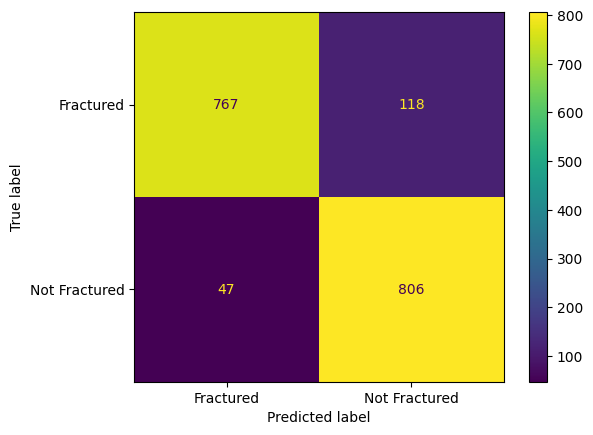

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        model = model.to(device)

        output = model(inputs.float().to(device)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ['Fractured', "Not Fractured"]

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
#df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     #columns = [i for i in classes])
cmdisplay = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = classes)
cmdisplay.plot()
pyplot.show()
# pyplot.figure(figsize = (12,7))
# sn.heatmap(df_cm, annot=True)
# pyplot.savefig('output.png')

In [ ]:
test(test_dataloader,model, loss_fn)

<ipython-input-4-89b71ddc6ddc>:69: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Test Error: 
 Accuracy: 90.5%, Avg loss: 1.216567 



1.2165667794285

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/model9.pth")

In [ ]:
!zip -r /content/jpgzipped.zip /content/X-ray_Images/JPG

In [ ]:
final_layer = model.module.layer4[2] # Grab the final layer of the model
print(final_layer)
#activated_features = SaveFeatures(final_layer) # attach the call back hook to the final layer of the model

Bottleneck(
  (conv1): Conv2d(2048, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
  (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)


In [ ]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}')
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [ ]:
backward_hook = final_layer.register_full_backward_hook(backward_hook, prepend=False)
forward_hook = final_layer.register_forward_hook(forward_hook, prepend=False)



In [ ]:
backward_hook.remove()
forward_hook.remove()

<ipython-input-4-89b71ddc6ddc>:69: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


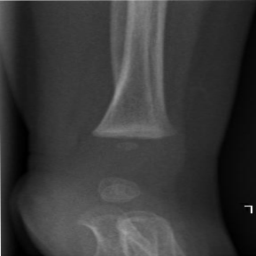

tensor([[[164, 162, 159,  ...,  33,  32,  28],
         [101,  97,  94,  ...,  31,  29,  25],
         [100,  94,  91,  ...,  28,  26,  22],
         ...,
         [218,  48,  45,  ...,   6,   6,   7],
         [222,  45,  42,  ...,   4,   4,   5],
         [223,  44,  41,  ...,   2,   2,   2]],

        [[164, 162, 159,  ...,  33,  32,  28],
         [101,  97,  94,  ...,  31,  29,  25],
         [100,  94,  91,  ...,  28,  26,  22],
         ...,
         [218,  48,  45,  ...,   6,   6,   7],
         [222,  45,  42,  ...,   4,   4,   5],
         [223,  44,  41,  ...,   2,   2,   2]],

        [[164, 162, 159,  ...,  33,  32,  28],
         [101,  97,  94,  ...,  31,  29,  25],
         [100,  94,  91,  ...,  28,  26,  22],
         ...,
         [218,  48,  45,  ...,   6,   6,   7],
         [222,  45,  42,  ...,   4,   4,   5],
         [223,  44,  41,  ...,   2,   2,   2]]], dtype=torch.uint8)


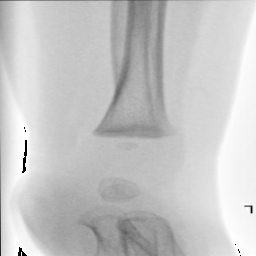

In [ ]:
from google.colab.patches import cv2_imshow
from torchvision.transforms.functional import to_pil_image

img = Image.open("/content/0563_0852376160_01_WRI-L2_M001.jpg")
x = transforms(img)
display(to_pil_image(x))
print(x)
x = x.type(torch.FloatTensor)

display(to_pil_image(x))
x = x.to(device)
model(x.unsqueeze(0)).sum().backward()


In [ ]:
conf = np.squeeze(model(x.unsqueeze(0)))
#print(conf)
cls = np.argmax(conf.cpu().detach().numpy())
class_names = ["Fractured", "Not Fractured"]
name = class_names[cls]
top_conf = conf[cls]
print(top_conf)
print(name)

tensor(43.1352, device='cuda:0', grad_fn=<SelectBackward0>)
Fractured


In [ ]:
out = model(x.unsqueeze(0))
#print(out)
class_prob = torch.softmax(out, dim=1)
#print(class_prob)
class_prob, topclass = torch.max(class_prob, dim=1)
print(topclass)

if topclass.cpu().numpy()[0] == 0:
  print("Fractured")
  print(class_prob[0]*100)
else:
  print("Not Fractured")
  print(class_prob[0].item()*100)


tensor([0], device='cuda:0')
Fractured
tensor(100., device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
# This one works
from torch.autograd import Variable
import torch.nn.functional as nnf
results = []
print('===============================================start')
index = 0
for num, data in enumerate(val_dataloader):
    #print(num)
    #print("=====================================================")

    imgs, label = data
    print(len(imgs))
    imgs,labels = imgs.to(device), label.to(device)
    test = Variable(imgs)
    output = model(test.type(torch.FloatTensor))
    #print(output)
    prob = nnf.softmax(output, dim=1)
    #print(prob)
    top_p, top_class = prob.topk(2, dim = 1)
    #top_p, top_class = ps.topk(1, dim = 1)
    results += [f"Index: {index} Class:{top_class.cpu().numpy().tolist()}, Prob: {top_p.cpu().detach().numpy().tolist()}"]
    index+=1
print(results)
# https://stackoverflow.com/questions/54513742/how-do-i-get-probability-confidence-as-output-for-a-cnn-using-keras-in-python?rq=3

===============================================start


<ipython-input-4-89b71ddc6ddc>:69: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32


KeyboardInterrupt: 

In [ ]:
logit = model(x.unsqueeze(0))
p = torch.nn.functional.softmax(logit, dim=1)
# to calculate loss using probabilities you can do below
print(p)
y = torch.tensor([0,1])
loss = torch.nn.functional.nll_loss(torch.log(p), y)

In [ ]:
print(gradients)

In [ ]:
print(pooled_gradients)

tensor([-1.0556, -0.2878, -0.8411,  ..., -4.5427, -0.2910, -0.6406],
       device='cuda:0')


In [ ]:
!cp /content/X-ray_Images/JPG/No\ Fracture/0563_0852376160_01_WRI-L2_M001.jpg /content/

In [ ]:
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

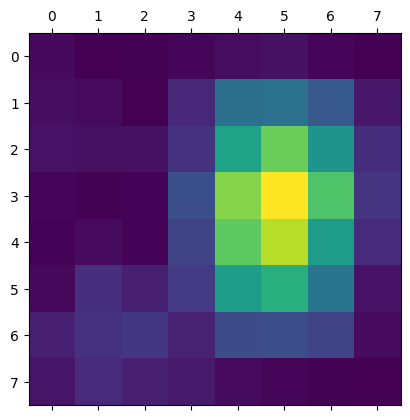

In [ ]:
# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
pyplot.matshow(heatmap.detach().cpu())

<ipython-input-4-89b71ddc6ddc>:69: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


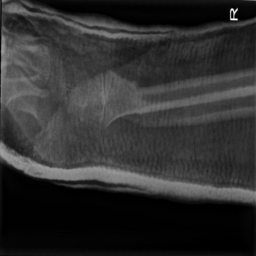

In [ ]:
adj = AdjustImage()
img = Image.open("/content/0003_0663715782_02_WRI-R2_M011.jpg")
display(to_pil_image(transforms(img)))


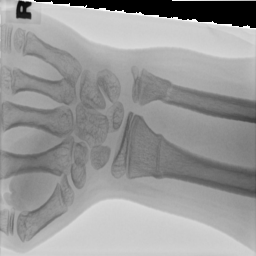

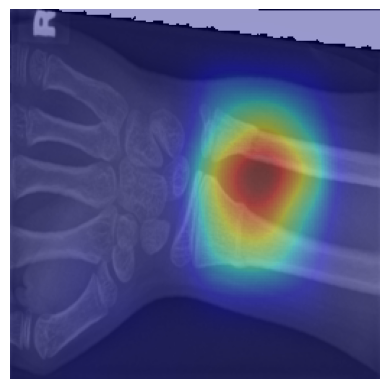

In [ ]:
from torchvision.transforms.functional import to_pil_image
import PIL
from matplotlib import colormaps
# Create a figure and plot the first image
fig, ax = pyplot.subplots()
ax.axis('off') # removes the axis markers
display(to_pil_image(x))
# First plot the original image
ax.imshow(PIL.ImageOps.invert(to_pil_image(x, mode='RGB')))

# Resize the heatmap to the same size as the input image and defines
# a resample algorithm for increasing image resolution
# we need heatmap.detach() because it can't be converted to numpy array while
# requiring gradients
overlay = to_pil_image(heatmap.detach(), mode='F').resize((256,256), resample=PIL.Image.BICUBIC)

# Apply any colormap you want
cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

# Plot the heatmap on the same axes,
# but with alpha < 1 (this defines the transparency of the heatmap)
ax.imshow(overlay, alpha=0.4, interpolation='nearest', extent=None)


# Show the plot
pyplot.savefig("test.jpg",bbox_inches='tight',pad_inches=0.0)


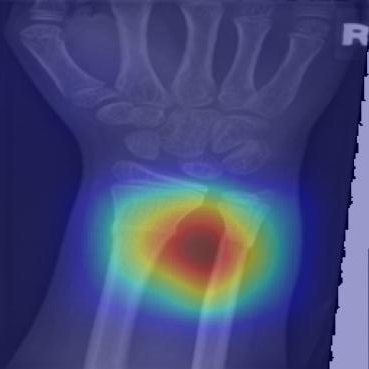

In [ ]:
img = Image.open("/content/test.jpg")
img_rotate = img.rotate(-90)
display(img_rotate)
img_rotate.save("/content/test.jpg")

###Faster RCNN:
https://debuggercafe.com/custom-object-detection-using-pytorch-faster-rcnn/

In [5]:
BATCH_SIZE = 16 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms
NUM_EPOCHS = 50 # number of epochs to train for
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)
# training images and XML files directory
TRAIN_DIR = '/content/Faster_RCNN/train'
# validation images and XML files directory
VALID_DIR = '/content/Faster_RCNN/test'

# test images for final case
TEST_DIR = '/content/Faster_RCNN/val'
# classes: 0 index is reserved for background
CLASSES = [
    'background', 'boneanomaly', 'bonelesion', 'foreignbody', 'fracture','metal',
    'periostealreaction','pronatorsign', 'axis', 'softtissue', 'text'
]
NUM_CLASSES = 11
# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = True
# location to save model and plots
OUT_DIR = '/content/outputs'
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs

cuda


In [6]:
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
#from config import DEVICE, CLASSES as classes
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [7]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [8]:
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

In [9]:
from xml.etree import ElementTree as et

In [10]:
# the dataset class
import re
import traceback
class FracturedDataset(torch.utils.data.Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
    def __getitem__(self, idx):
        # capture the image name and the full image path


          image_name = self.all_images[idx]
          image_path = os.path.join(self.dir_path, image_name)
          # read the image
          image = cv2.imread(image_path)
          # convert BGR to RGB color format
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
          image_resized = cv2.resize(image, (self.width, self.height))
          #image_resized /= 255.0

          # capture the corresponding XML file for getting the annotations
          annot_filename = image_name[:-4] + '.xml'
          annot_file_path = os.path.join(self.dir_path, annot_filename)

          boxes = []
          labels = []
          tree = et.parse(annot_file_path)
          root = tree.getroot()

          # get the height and width of the image
          image_width = image.shape[1]
          image_height = image.shape[0]

          # box coordinates for xml files are extracted and corrected for image size given
          for member in root.findall('object'):
              # map the current object name to `classes` list to get...
              # ... the label index and append to `labels` list

              labels.append(self.classes.index(re.sub(r"[\n\t\s]*", "", member.find('name').text)))

              # xmin = left corner x-coordinates
              xmin = int(member.find('bndbox').find('xmin').text)
              # xmax = right corner x-coordinates
              xmax = int(member.find('bndbox').find('xmax').text)
              # ymin = left corner y-coordinates
              ymin = int(member.find('bndbox').find('ymin').text)
              # ymax = right corner y-coordinates
              ymax = int(member.find('bndbox').find('ymax').text)

              # resize the bounding boxes according to the...
              # ... desired `width`, `height`
              xmin_final = (xmin/image_width)*self.width
              xmax_final = (xmax/image_width)*self.width
              ymin_final = (ymin/image_height)*self.height
              yamx_final = (ymax/image_height)*self.height

              boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])

          # bounding box to tensor
          boxes = torch.as_tensor(boxes, dtype=torch.float32)
          # area of the bounding boxes
          area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
          # no crowd instances
          iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
          # labels to tensor
          labels = torch.as_tensor(labels, dtype=torch.int64)
          # prepare the final `target` dictionary
          target = {}
          target["boxes"] = boxes
          target["labels"] = labels
          target["area"] = area
          target["iscrowd"] = iscrowd
          image_id = torch.tensor([idx])
          target["image_id"] = image_id
          # apply the image transforms
          if self.transforms:
              sample = self.transforms(image = image_resized,
                                      bboxes = target['boxes'],
                                      labels = labels)
              image_resized = sample['image']
              target['boxes'] = torch.Tensor(sample['bboxes'])

          return image_resized, target
       # except Exception as e:
          #print(image_name)
        #  traceback.print_exc()
         # print(idx)
    def __len__(self):
        return len(self.all_images)

In [ ]:
from google.colab.patches import cv2_imshow
def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            cv2_imshow(sample)


In [16]:
dataset = FracturedDataset(
    "C:\\Users\\jenni\\Desktop\\Diss_Work\\Faster_RCNN_with_no_bb\\train", RESIZE_TO, RESIZE_TO, CLASSES
)
print(f"Number of training images: {len(dataset)}")
with_bb = 0
without_bb = 0
total = 0
np_count = 0
for target in dataset:
   
    
  fn, fe =  os.path.splitext(element)

    #print(element)\
  #print(type(image), type(target))
    total += 1
    
    # if 4  in target['labels']:
    #   with_bb += 1
    # else:
    #   without_bb += 1

print(f"with: {with_bb}, without: {without_bb}, total: {total}, length {len(dataset)}" )

Number of training images: 11326
with: 0, without: 0, total: 8935, length 11326


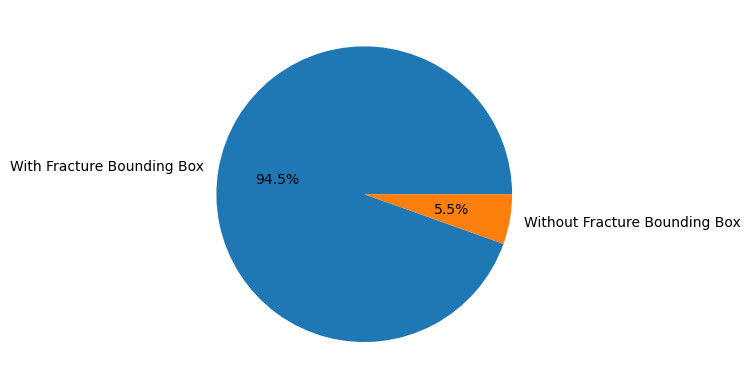

In [18]:
import matplotlib.pyplot as plt

labels = 'With Fracture Bounding Box', 'Without Fracture Bounding Box'
sizes = [13385,773]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.show()

In [ ]:
# prepare the final datasets and data loaders
train_rcnn_dataset = FracturedDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform())
valid_rcnn_dataset = FracturedDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())
test_rcnn_dataset = FracturedDataset(TEST_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform())

train_rcnn_loader = DataLoader(
    train_rcnn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_rcnn_loader = DataLoader(
    valid_rcnn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
test_rcnn_loader = DataLoader(
    test_rcnn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_rcnn_dataset)}")
print(f"Number of validation samples: {len(valid_rcnn_dataset)}\n")
print(f"Number of test samples: {len(test_rcnn_dataset)}\n")

Number of training samples: 6422
Number of validation samples: 790

Number of test samples: 798



In [14]:
#@title testing
#from google.colab.patches import cv2_imshow
dataset = FracturedDataset(
    "C:\\Users\\jenni\\Desktop\\Diss_Work\\Faster_RCNN\\train", RESIZE_TO, RESIZE_TO, CLASSES
)
print(f"Number of training images: {len(dataset)}")

# function to visualize a single sample
def visualize_sample(image, target):
  for i in range(len(target['boxes'])):
    box = target['boxes'][i]
    label = CLASSES[target['labels'][i]]
    cv2.rectangle(
        image,
        (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
        (0, 255, 0), 1
    )
    cv2.putText(
        image, label, (int(box[0]), int(box[1]-5)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2
    )
  cv2.imshow("img",image)
    #cv2.waitKey(0)

NUM_SAMPLES_TO_VISUALIZE = 10
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
    if 4 not in target['labels']:
      print("Fractured X-ray, but no bounding box")
    else:
      visualize_sample(image, target)

Number of training images: 10704


: 

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# load Faster RCNN pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)

# get the number of input features
in_features = model.roi_heads.box_predictor.cls_score.in_features
# define a new head for the detector with required number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(CLASSES))
model = nn.DataParallel(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 180MB/s]


In [ ]:
from tqdm.auto import tqdm

import torch
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

In [ ]:
# function for running training iterations
def train_rcnn(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [ ]:
# function for running validation iterations
def test_rcnn(valid_data_loader, model):
    print('Validating')
    global test_itr
    global test_rcnn_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(test_rcnn_loader, total=len(test_rcnn_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        test_rcnn_loss_list.append(loss_value)
        test_rcnn_loss_hist.send(loss_value)
        test_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return test_rcnn_loss_list

In [ ]:
print(len(train_rcnn_loader))

402


In [ ]:
torch.cuda.empty_cache()

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 492345, done.
remote: Counting objects: 100% (5955/5955), done.
remote: Compressing objects: 100% (374/374), done.
remote: Total 492345 (delta 5585), reused 5918 (delta 5569), pack-reused 486390
Receiving objects: 100% (492345/492345), 952.73 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (458820/458820), done.
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:
evaluate(model, test_rcnn_loader, device=DEVICE)

In [ ]:
#@title Engine
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

#from coco_utils import get_coco_api_from_dataset
#from coco_eval import CocoEvaluator
#import utils


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator


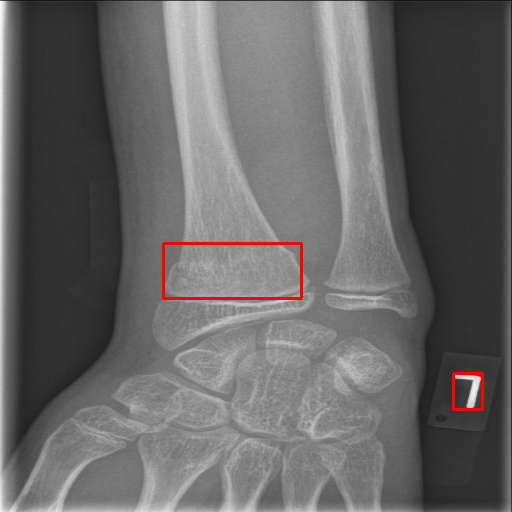


EPOCH 1 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #0 train loss: 0.421
Epoch #0 validation loss: 0.315
Took 4.249 minutes for epoch 0

EPOCH 2 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #1 train loss: 0.306
Epoch #1 validation loss: 0.291
Took 4.177 minutes for epoch 1
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 3 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #2 train loss: 0.282
Epoch #2 validation loss: 0.281
Took 4.180 minutes for epoch 2

EPOCH 4 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #3 train loss: 0.268
Epoch #3 validation loss: 0.276
Took 4.177 minutes for epoch 3
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 5 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #4 train loss: 0.258
Epoch #4 validation loss: 0.269
Took 4.176 minutes for epoch 4

EPOCH 6 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #5 train loss: 0.254
Epoch #5 validation loss: 0.266
Took 4.173 minutes for epoch 5
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 7 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #6 train loss: 0.251
Epoch #6 validation loss: 0.258
Took 4.163 minutes for epoch 6

EPOCH 8 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #7 train loss: 0.246
Epoch #7 validation loss: 0.255
Took 4.165 minutes for epoch 7
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 9 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #8 train loss: 0.240
Epoch #8 validation loss: 0.252
Took 4.169 minutes for epoch 8

EPOCH 10 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #9 train loss: 0.239
Epoch #9 validation loss: 0.249
Took 4.172 minutes for epoch 9
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 11 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #10 train loss: 0.234
Epoch #10 validation loss: 0.245
Took 4.172 minutes for epoch 10

EPOCH 12 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #11 train loss: 0.232
Epoch #11 validation loss: 0.243
Took 4.168 minutes for epoch 11
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 13 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #12 train loss: 0.230
Epoch #12 validation loss: 0.239
Took 4.169 minutes for epoch 12

EPOCH 14 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #13 train loss: 0.229
Epoch #13 validation loss: 0.240
Took 4.169 minutes for epoch 13
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 15 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #14 train loss: 0.226
Epoch #14 validation loss: 0.238
Took 4.169 minutes for epoch 14

EPOCH 16 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #15 train loss: 0.225
Epoch #15 validation loss: 0.237
Took 4.172 minutes for epoch 15
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 17 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #16 train loss: 0.222
Epoch #16 validation loss: 0.230
Took 4.173 minutes for epoch 16

EPOCH 18 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #17 train loss: 0.219
Epoch #17 validation loss: 0.231
Took 4.178 minutes for epoch 17
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 19 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #18 train loss: 0.219
Epoch #18 validation loss: 0.231
Took 4.172 minutes for epoch 18

EPOCH 20 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #19 train loss: 0.218
Epoch #19 validation loss: 0.231
Took 4.174 minutes for epoch 19
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 21 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #20 train loss: 0.218
Epoch #20 validation loss: 0.231
Took 4.169 minutes for epoch 20

EPOCH 22 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #21 train loss: 0.217
Epoch #21 validation loss: 0.229
Took 4.177 minutes for epoch 21
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 23 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #22 train loss: 0.215
Epoch #22 validation loss: 0.232
Took 4.173 minutes for epoch 22

EPOCH 24 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #23 train loss: 0.213
Epoch #23 validation loss: 0.229
Took 4.172 minutes for epoch 23
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 25 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #24 train loss: 0.213
Epoch #24 validation loss: 0.231
Took 4.174 minutes for epoch 24

EPOCH 26 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #25 train loss: 0.212
Epoch #25 validation loss: 0.228
Took 4.174 minutes for epoch 25
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 27 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #26 train loss: 0.210
Epoch #26 validation loss: 0.230
Took 4.177 minutes for epoch 26

EPOCH 28 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #27 train loss: 0.210
Epoch #27 validation loss: 0.232
Took 4.168 minutes for epoch 27
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 29 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #28 train loss: 0.210
Epoch #28 validation loss: 0.233
Took 4.173 minutes for epoch 28

EPOCH 30 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #29 train loss: 0.209
Epoch #29 validation loss: 0.230
Took 4.174 minutes for epoch 29
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 31 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #30 train loss: 0.208
Epoch #30 validation loss: 0.228
Took 4.173 minutes for epoch 30

EPOCH 32 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #31 train loss: 0.207
Epoch #31 validation loss: 0.231
Took 4.172 minutes for epoch 31
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 33 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #32 train loss: 0.206
Epoch #32 validation loss: 0.228
Took 4.172 minutes for epoch 32

EPOCH 34 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #33 train loss: 0.206
Epoch #33 validation loss: 0.229
Took 4.174 minutes for epoch 33
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 35 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #34 train loss: 0.204
Epoch #34 validation loss: 0.231
Took 4.172 minutes for epoch 34

EPOCH 36 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #35 train loss: 0.204
Epoch #35 validation loss: 0.230
Took 4.177 minutes for epoch 35
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 37 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #36 train loss: 0.203
Epoch #36 validation loss: 0.231
Took 4.174 minutes for epoch 36

EPOCH 38 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #37 train loss: 0.201
Epoch #37 validation loss: 0.233
Took 4.175 minutes for epoch 37
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 39 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #38 train loss: 0.202
Epoch #38 validation loss: 0.231
Took 4.179 minutes for epoch 38

EPOCH 40 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #39 train loss: 0.200
Epoch #39 validation loss: 0.230
Took 4.174 minutes for epoch 39
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 41 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #40 train loss: 0.199
Epoch #40 validation loss: 0.231
Took 4.179 minutes for epoch 40

EPOCH 42 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #41 train loss: 0.200
Epoch #41 validation loss: 0.230
Took 4.173 minutes for epoch 41
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 43 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #42 train loss: 0.198
Epoch #42 validation loss: 0.232
Took 4.175 minutes for epoch 42

EPOCH 44 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #43 train loss: 0.197
Epoch #43 validation loss: 0.228
Took 4.179 minutes for epoch 43
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 45 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #44 train loss: 0.196
Epoch #44 validation loss: 0.231
Took 4.179 minutes for epoch 44

EPOCH 46 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #45 train loss: 0.196
Epoch #45 validation loss: 0.229
Took 4.181 minutes for epoch 45
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 47 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #46 train loss: 0.194
Epoch #46 validation loss: 0.233
Took 4.180 minutes for epoch 46

EPOCH 48 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #47 train loss: 0.194
Epoch #47 validation loss: 0.229
Took 4.180 minutes for epoch 47
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...

EPOCH 49 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #48 train loss: 0.193
Epoch #48 validation loss: 0.228
Took 4.180 minutes for epoch 48

EPOCH 50 of 50
Training


  0%|          | 0/402 [00:00<?, ?it/s]

Validating


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #49 train loss: 0.191
Epoch #49 validation loss: 0.230
Took 4.181 minutes for epoch 49
SAVING MODEL COMPLETE...

SAVING PLOTS COMPLETE...


In [ ]:
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# initialize the Averager class
train_loss_hist = Averager()
test_rcnn_loss_hist = Averager()
train_itr = 1
test_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
test_rcnn_loss_list = []
# name to save the trained model with
MODEL_NAME = 'model'
# whether to show transformed images from data loader or not
if VISUALIZE_TRANSFORMED_IMAGES:
    #from utils import show_tranformed_image
    show_tranformed_image(train_rcnn_loader)
# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    test_rcnn_loss_hist.reset()
    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, test_ax = plt.subplots()
    # start timer and carry out training and validation
    start = time.time()
    train_loss = train_rcnn(train_rcnn_loader, model)
    test_loss = test_rcnn(test_rcnn_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validation loss: {test_rcnn_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    #evaluate(model, test_rcnn_loader, device=DEVICE)
    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        test_ax.plot(test_loss, color='red')
        test_ax.set_xlabel('iterations')
        test_ax.set_ylabel('test loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/test_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        test_ax.plot(test_loss, color='red')
        test_ax.set_xlabel('iterations')
        test_ax.set_ylabel('test loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/test_loss_{epoch+1}.png")
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

    plt.close('all')

In [ ]:
!cp -R "/content/outputs" "/content/drive/My Drive/outputs"

In [ ]:
import numpy as np
import cv2
import torch
import glob as glob

# set the computation device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# load the model and the trained weights
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)

# get the number of input features
in_features = model.roi_heads.box_predictor.cls_score.in_features
# define a new head for the detector with required number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(CLASSES))
model = nn.DataParallel(model)
model.load_state_dict(torch.load(
    '/content/outputs/model50.pth', map_location=device
))
model.eval()

DataParallel(
  (module): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, mo

In [ ]:
# directory where all the images are present
VAL_DIR = '/content/Faster_RCNN/val'
test_images = glob.glob(f"{VAL_DIR}/*")
print(f"Test instances: {len(test_images)}")
# classes: 0 index is reserved for background
CLASSES = [
    'background', 'boneanomaly', 'bonelesion', 'foreignbody', 'fracture','metal',
    'periostealreaction','pronatorsign', 'axis', 'softtissue', 'text'
]
# define the detection threshold...
# ... any detection having score below this will be discarded
detection_threshold = 0.70

Test instances: 1596


/content/Faster_RCNN/val/2157_0998197067_02_WRI-L1_M012.jpg


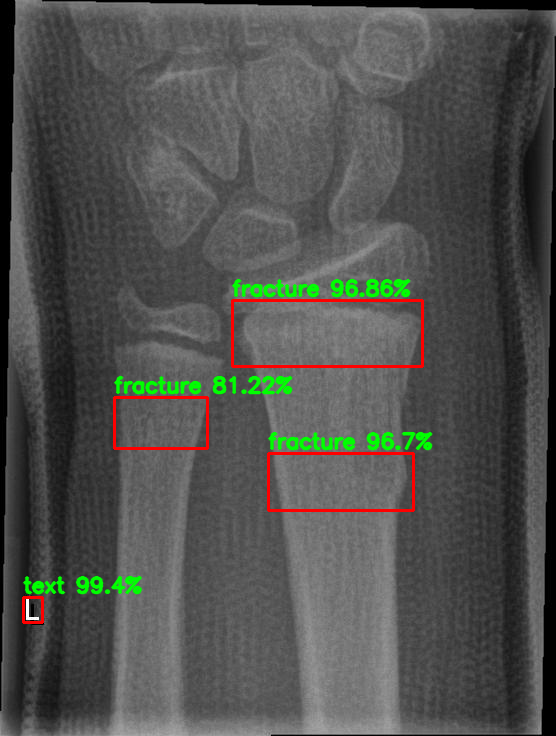

Image 1 done...
--------------------------------------------------
xml file
/content/Faster_RCNN/val/1398_1011681844_02_WRI-L2_F012.jpg


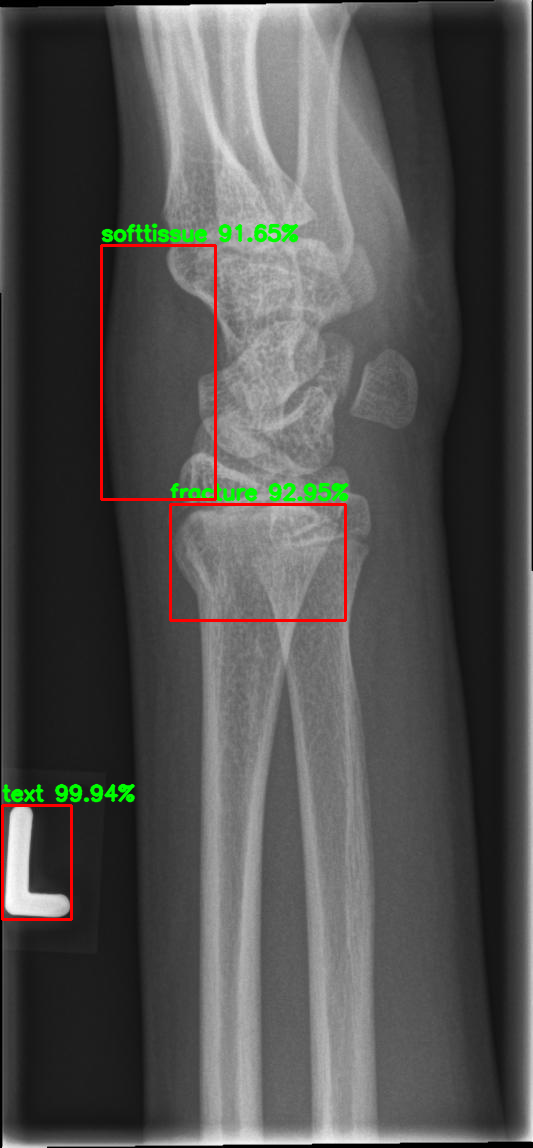

Image 3 done...
--------------------------------------------------
/content/Faster_RCNN/val/0031_1006577868_01_WRI-R1_M009.jpg


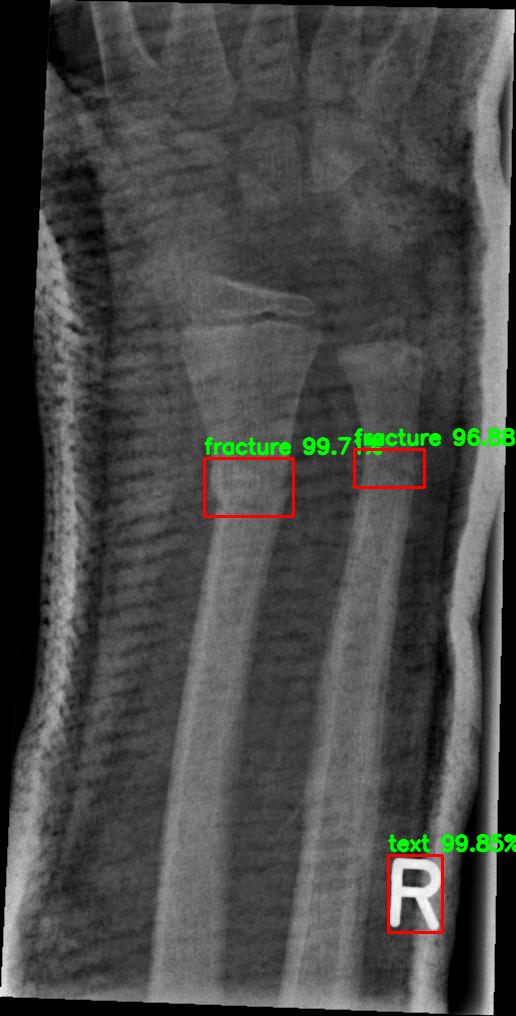

Image 4 done...
--------------------------------------------------
xml file
xml file
/content/Faster_RCNN/val/4692_0833864661_04_WRI-R2_M012.jpg


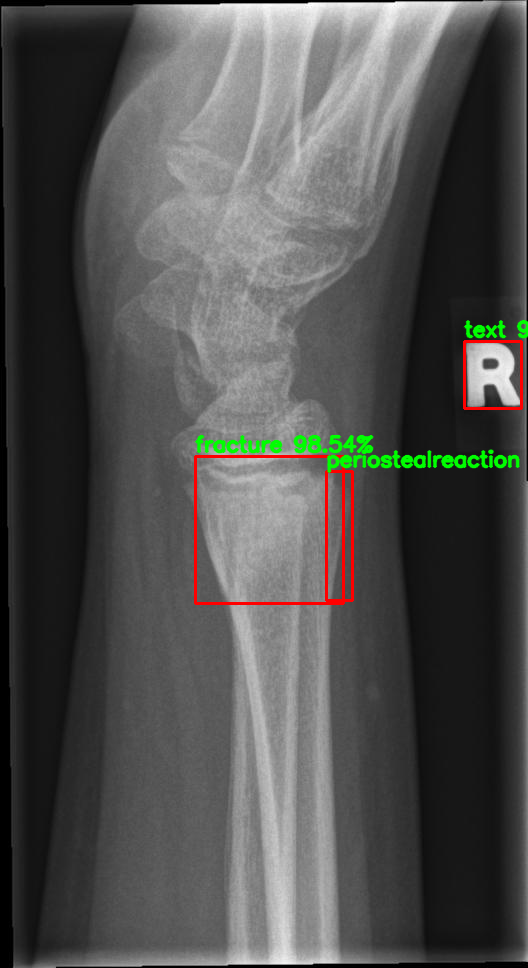

Image 7 done...
--------------------------------------------------
xml file
/content/Faster_RCNN/val/1280_0847425904_01_WRI-R1_F016.jpg


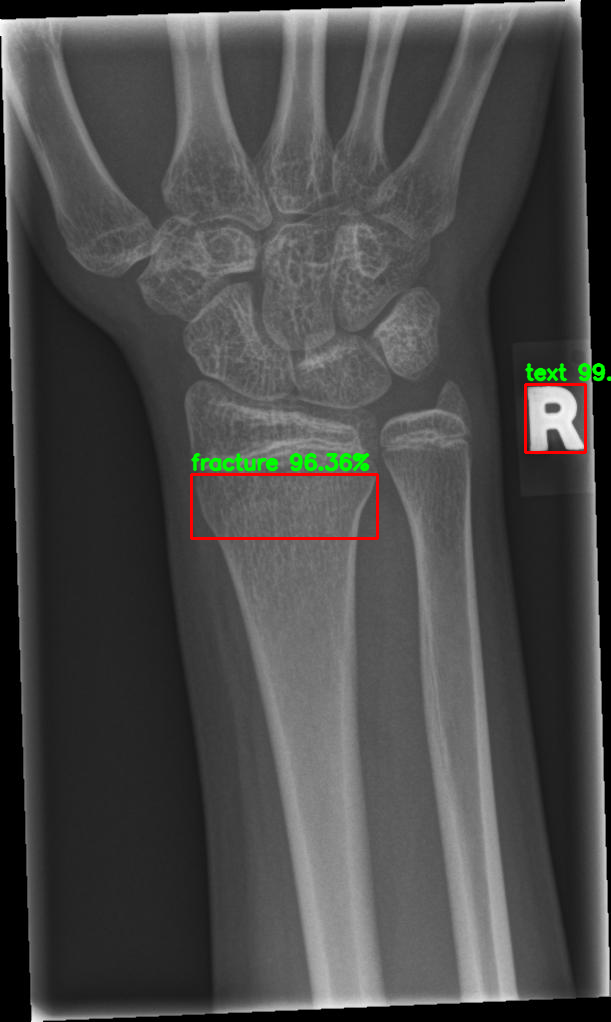

Image 9 done...
--------------------------------------------------
/content/Faster_RCNN/val/1279_0451532068_02_WRI-L1_F007.jpg


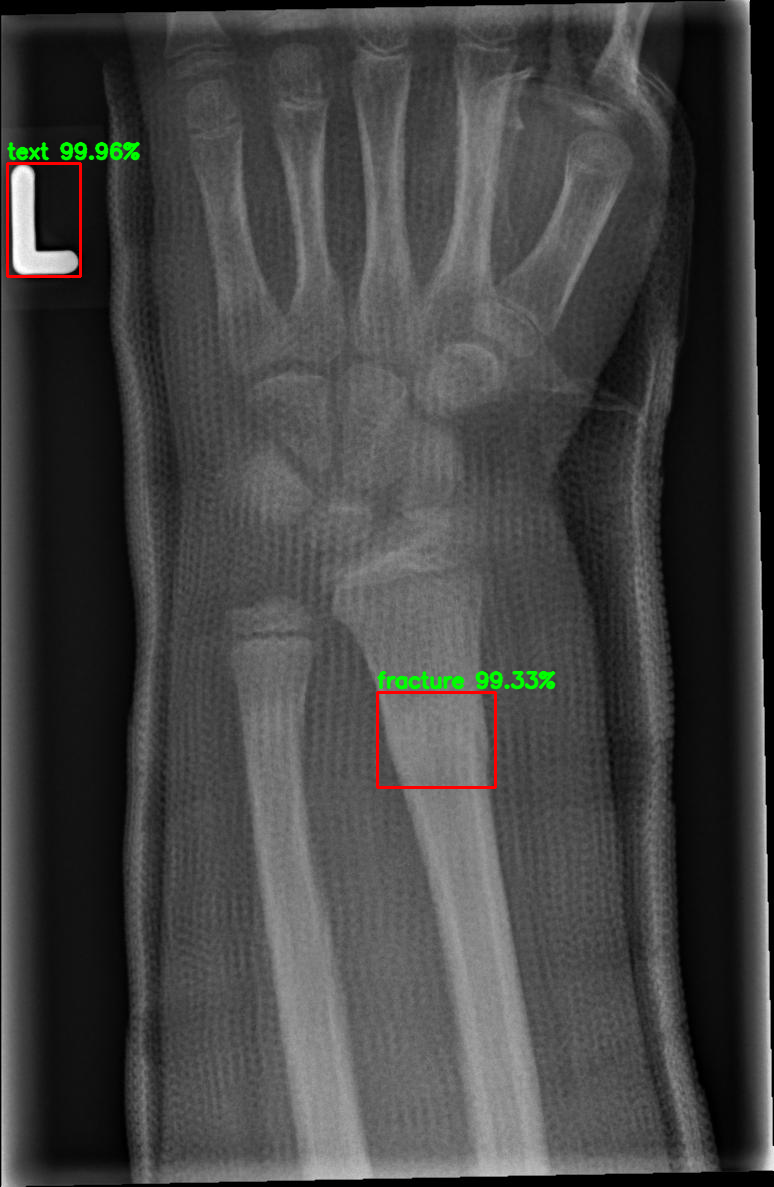

Image 10 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE


In [ ]:
for i in range(10):
    # get the image file name for saving output later on
    fn, fe = os.path.splitext(test_images[i])
    if fe == ".xml":
      print("xml file")
    else:
      image_name = test_images[i].split('/')[-1].split('.')[0]
      print(test_images[i])
      image = cv2.imread(test_images[i])
      orig_image = image.copy()
      # BGR to RGB
      image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
      # make the pixel range between 0 and 1
      #image /= 255.0
      # bring color channels to front
      image = np.transpose(image, (2, 0, 1)).astype(float)
      # convert to tensor
      image = torch.tensor(image, dtype=torch.float).cuda()
      # add batch dimension
      image = torch.unsqueeze(image, 0)
      with torch.no_grad():
          outputs = model(image)

      # load all detection to CPU for further operations
      outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
      # carry further only if there are detected boxes
      if len(outputs[0]['boxes']) != 0:
          boxes = outputs[0]['boxes'].data.numpy()
          scores = outputs[0]['scores'].data.numpy()
          # filter out boxes according to `detection_threshold`
          boxes = boxes[scores >= detection_threshold].astype(np.int32)
          draw_boxes = boxes.copy()
          # get all the predicited class names
          pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

          # draw the bounding boxes and write the class name on top of it
          for j, box in enumerate(draw_boxes):
              cv2.rectangle(orig_image,
                          (int(box[0]), int(box[1])),
                          (int(box[2]), int(box[3])),
                          (0, 0, 255), 2)
              cv2.putText(orig_image, str(pred_classes[j]) + " " + str(round(scores[j]*100,2)) + "%",
                          (int(box[0]), int(box[1]-5)),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0),
                          2, lineType=cv2.LINE_AA)
          cv2_imshow(orig_image)
          #cv2.waitKey(1)
          cv2.imwrite(f"../test_predictions/{image_name}.jpg", orig_image,)
      print(f"Image {i+1} done...")
      print('-'*50)
print('TEST PREDICTIONS COMPLETE')
#cv2.destroyAllWindows()